# NOAA Dataset

In [600]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from skmultiflow.data import HyperplaneGenerator
from sklearn import metrics
import scipy.stats as stats
from scipy.stats import norm

import random
from numpy.random import seed
from numpy.random import randn
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import anderson

import tensorflow
import tensorflow.keras.backend as K
import tensorflow.keras.layers as layers

import warnings
warnings.filterwarnings('ignore')


In [601]:
df=pd.read_csv("D:/Concept Drift Papers for Proposal Defence/Datasets/NOAA.csv")

In [602]:
df

attribute1  attribute2  attribute3  attribute4  attribute5  attribute6  \
0            19.8        14.0      1019.6         8.4         9.9        15.9   
1            26.8        22.2      1006.2         8.1        10.9        19.0   
2            34.6        32.9      1004.6         3.9        13.8        22.0   
3            26.4        21.5      1006.9         8.0        18.7        30.1   
4            14.7         7.9      1009.9         8.1        14.1        22.0   
...           ...         ...         ...         ...         ...         ...   
18154        32.6        21.9      1022.7         7.0        12.4        26.0   
18155        36.8        25.4      1014.9         7.0        10.0        19.0   
18156        41.9        29.9      1010.0         7.0         4.7         9.9   
18157        42.4        29.7      1011.3         7.0         3.3         8.9   
18158        36.6        29.5      1017.9         6.8         4.8        13.0   

       attribute7  attribute8  class  
0            28.9        14.0      1  
1            34.0        21.0      1  
2            36.0        33.1      2  
3            39.9        16.0      2  
4            21.0         9.0      1  
...           ...         ...    ...  
18154        41.0        24.8      2  
18155        57.2        21.2      1  
18156        62.6        28.4      1  
18157        51.8        32.0      1  
18158        53.6        24.8      1  

[18159 rows x 9 columns]

In [603]:
df['class'].value_counts(normalize=True)

1    0.686216
2    0.313784
Name: class, dtype: float64

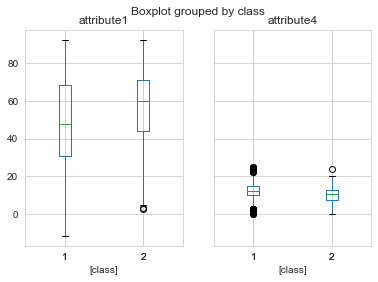

In [604]:
boxplot = df.boxplot(column=['attribute1','attribute4'], by=['class'])

<AxesSubplot:xlabel='class', ylabel='attribute7'>

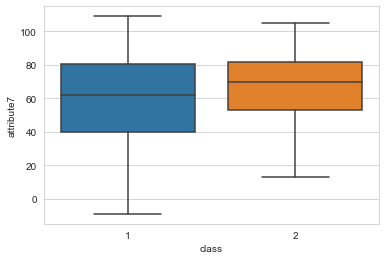

In [605]:
sns.boxplot( x = 'class',y = 'attribute7', data = df )

In [606]:
#data_neg=df[df['class']==1]  # No Rain

In [607]:
#data_pos=df[df['class']==2] # Rain

In [608]:
def encode_all(data,label_col):
        
    # Apply Label Encoding
    encoder=LabelEncoder()
    for col in data.columns:
        if ((data[col].dtype=='object')and (col!=label_col)): 
            data = pd.get_dummies(data, columns=[col])
            
   # Apply Minmax Normalization 
    for col in data.columns:
        if (((data[col].dtype=='float64')or(data[col].dtype=='int64')) and (col!=label_col)): 
            data[col] = np.round((data[col] - data[col].min()) / (data[col].max() - data[col].min()) ,3)  
        
    train=data[0:int(len(data)*0.80)]
    test=data[int((0.80*len(data))):int((0.90*len(data)))]
    stream=data[int((0.90*len(data))):len(data)]
    
    train_positives = train[train[label_col] == 2]
    train_negatives = train[train[label_col] == 1]
    
    X_positive=train_positives.drop([label_col],axis=1)
    X_negative=train_negatives.drop([label_col],axis=1)
    return data , train, test, X_positive,X_negative , stream 

In [609]:
data , train, test, X_positive,X_negative , stream =encode_all(df,'class')

In [610]:
stream['class'].value_counts()

1    1165
2     651
Name: class, dtype: int64

In [611]:
def autoencoder (train,epochs,val_set):
    
    # set bottleneck 1/3 of the input layer size
    encoding_dim = int(np.floor(train.shape[-1]/3))
    
    # input layer size= # of attributes in the dataset after one-hot encoding
    input_layer = tensorflow.keras.Input(shape=train.shape[1:]) # Input Layer
    
    encoded = layers.Dense(encoding_dim, activation='sigmoid')(input_layer) # Code Layer
    decoded = layers.Dense(train.shape[1], activation='sigmoid')(encoded) # Output Laye
       
    
    autoencoder = tensorflow.keras.Model(input_layer, decoded)
    # above model maps an input to its reconstruction 
    
    encoder = tensorflow.keras.Model(input_layer, encoded)
    # above model maps input to its encoded representation 
    
   
    encoded_input = tensorflow.keras.Input(shape=(encoding_dim,))# Encoded Input
    decoder_layer = autoencoder.layers[-1]# Retrieve last layer of autoencoder model defined above
    decoder = tensorflow.keras.Model(encoded_input, decoder_layer(encoded_input))# Decoder Model
          
    autoencoder.compile(optimizer='adam', loss='mse') # Train autoencoder 
    history=autoencoder.fit(train,train, 
                epochs=epochs,
                batch_size=32,
                shuffle=True,
                validation_data=(val_set, val_set)).history
    return  autoencoder , history

In [612]:
def train_encoders(X_Positive,X_Negative, epochs):
    
    X_Positive_train=X_Positive[0:int(len(X_Positive)*0.90)]
    X_Positive_test=X_Positive[int((0.90*len(X_Positive))):len(X_Positive)-1]
    
    X_Negative_train=X_Negative[0:int(len(X_Negative)*0.90)]
    X_Negative_test=X_Negative[int((0.90*len(X_Negative))):len(X_Negative)-1]

    print("Training Autoencoder on Positive Examples ")
    encoder_pos_class, history_positive_class=autoencoder(X_Positive_train,epochs,X_Positive_test)
    print("Training Autoencoder on Negative Examples ")
    encoder_neg_class,history_negative_class=autoencoder(X_Negative_train,epochs,X_Negative_test)
    
    return encoder_pos_class, history_positive_class ,encoder_neg_class,history_negative_class

In [613]:
encoder_pos_class, history_positive_class ,encoder_neg_class,history_negative_class=train_encoders(X_positive,X_negative,100)

Training Autoencoder on Positive Examples 
Epoch 1/100
125/125 [==============================] - 1s 3ms/step - loss: 0.0804 - val_loss: 0.0616
Epoch 2/100
125/125 [==============================] - 0s 2ms/step - loss: 0.0551 - val_loss: 0.0435
Epoch 3/100
125/125 [==============================] - 0s 2ms/step - loss: 0.0399 - val_loss: 0.0331
Epoch 4/100
125/125 [==============================] - 0s 2ms/step - loss: 0.0316 - val_loss: 0.0272
Epoch 5/100
125/125 [==============================] - 0s 2ms/step - loss: 0.0266 - val_loss: 0.0237
Epoch 6/100
125/125 [==============================] - 0s 2ms/step - loss: 0.0239 - val_loss: 0.0216
Epoch 7/100
125/125 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0202
Epoch 8/100
125/125 [==============================] - 0s 2ms/step - loss: 0.0217 - val_loss: 0.0192
Epoch 9/100
125/125 [==============================] - 0s 2ms/step - loss: 0.0206 - val_loss: 0.0184
Epoch 10/100
125/125 [==========================

In [614]:
#Plot the model loss(train/test) for give number of epochs
def plot_loss(history):
    plt.plot(history['loss'], linewidth=2, label='Training_Loss')
    plt.plot(history['val_loss'], linewidth=2, label='Validation_Loss')
    plt.legend(loc='upper right')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    #plt.ylim(ymin=0.70,ymax=1)
    plt.show()

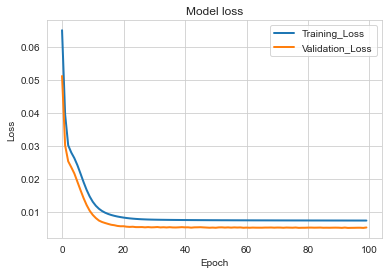

In [615]:
plot_loss(history_negative_class)

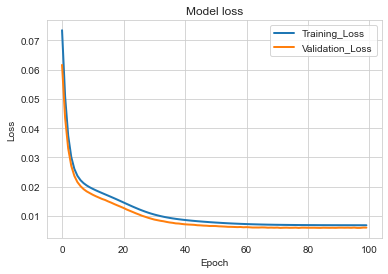

In [616]:
plot_loss(history_positive_class)

In [617]:
def mse_predictions(test, encoder):
    #test=data[int((0.66*len(data))):len(data)-1]
    #pos_test, neg_test=encode(test)
    #Y_test=test['class']
    #X_test=test.drop(['class'],axis=1)
    test=np.array(test)
    predictions=[]
    for i in range(0, test.shape[0]):
        ROW = np.array([test[i]])
        pred= encoder.predict(ROW) 
        mse = np.mean(np.power(test[i] - pred, 2))
        predictions.append(mse)
        #print(test[i] ,pred,mse)
    return predictions

In [618]:
def plot_results(predictions):
    df=pd.DataFrame(predictions,columns=['MSE'])
    #df['class']=pd.Series(Y_test)
    df['MSE']=df['MSE'].round(2)
    #df_positive_class=df[df['class']==1]
    #df_negative_class=df[df['class']==0]
   
    mean=np.round(np.mean( df['MSE']),3)
    max=np.round(np.max( df['MSE']),3)
    min=np.round(np.min( df['MSE']),3)
    var=np.round(np.var( df['MSE']),3)
    med=np.round(np.median(df['MSE']),3)
    
    
    f, axes = plt.subplots(1, 2,figsize=(16,4))
    f.suptitle('Boxplots and Normal Distribution plot for MSE Distribution')
    #axes[0, 0].set_title('MSE of Positive Class')
    sns.boxplot(x=df['MSE'], data=df, ax=axes[0])
    #axes[0, 1].set_title('MSE of Negative Class')    
    #sns.boxplot(x=df_negative_class['MSE'], data=df_negative_class  , ax=axes[1])
    sns.distplot(x=df['MSE'],  ax=axes[1])
    print('mean={},median={} ,max={},min={},variance={}'.format(mean,med,max,min,var))
    
    fig, ax = plt.subplots(figsize=(16,5))
    ax.set_title('MSE plot ')
    plt.plot(df['MSE'],label="MSE")
    #plt.plot(df_positive_class['MSE'],label="MSE of Positive Class")
    plt.legend()
    plt.show()  
    #return df

In [619]:
test_pos_class=test[test['class']==2]
test_neg_class=test[test['class']==1]

In [620]:
del test_pos_class['class']
del test_neg_class['class']

In [621]:
predictions_neg=mse_predictions(test_neg_class,encoder_neg_class)

mean=0.005,median=0.0 ,max=0.06,min=0.0,variance=0.0


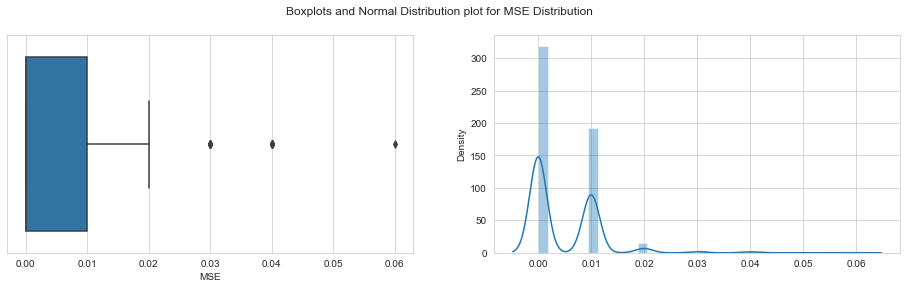

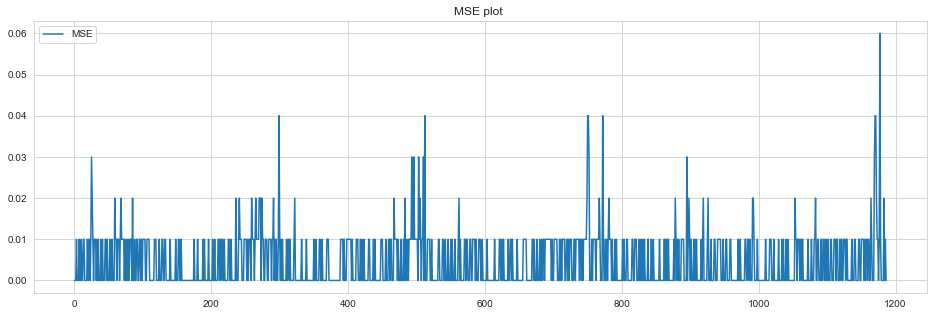

In [622]:
plot_results(predictions_neg)

In [623]:
def make_batches(test_data):
    data=np.array(test_data)
    batch_size=32
    batches={}
    count=0
    for index in range(0,data.shape[0],batch_size):
        batches[count]=data[index:min(index+batch_size,data.shape[0]),:]
        count+=1
    return batches,batch_size
    #print(batch.shape) 

In [624]:
batches_neg,batch_size=make_batches(test_neg_class)

In [625]:
type(batches_neg)

dict

In [626]:
# Anderson-Darling Test
def Anderson_Darling(data):
    result = anderson(data)
    print('Statistic: %.3f' % result.statistic)
    p = 0
    for i in range(len(result.critical_values)):
        sl, cv = result.significance_level[i], result.critical_values[i]
        if result.statistic < result.critical_values[i]:
            print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
        else:
            print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

In [627]:
# D'Agostino and Pearson's Test
def D_Agostino(data):
    stat, p = normaltest(data)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

In [628]:
# Shapiro-Wilk Test
def Shapiro_Wilk(data):
    stat, p = shapiro(data)
    print('Statistics=%.3f, p=%.10f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

In [629]:
def compute_instance_loss_batch_loss(batch,batch_size,encoder):
    mse_list=[]
    mse_sum=0  
    for i in range(0,batch.shape[0]):
        ROW = np.array([batch[i]])
        pred= encoder.predict(ROW) 
        mse = np.round(np.mean(np.power(batch[i] - pred, 2)),5)
        mse_list.append(mse)
        mse_sum+=mse
    avg_mse=mse_sum/batch_size
    return mse_list,avg_mse   
    

In [630]:
def check_all_batch_normality(batches,encoder,batch_size):
    batch_avg_mse=[]
    batch_mse_values={}
    for b in batches:
        print("\n ********************")
        print('Batch: {}'.format(b))
        mse_list,average_mse=compute_instance_loss_batch_loss(batches[b],batch_size,encoder)
        plot_results(mse_list)
        
        print("\nShapiro_Wilk Test")
        #Shapiro_Wilk(mse_list)
       # print("D_Agostino Test")
       # D_Agostino(mse_list)
        print("\nAnderson_Darling Test")
        #Anderson_Darling(mse_list)
        batch_avg_mse.append(average_mse)
        batch_mse_values[b]=mse_list
    return batch_avg_mse,batch_mse_values


 ********************
Batch: 0
mean=0.006,median=0.0 ,max=0.03,min=0.0,variance=0.0


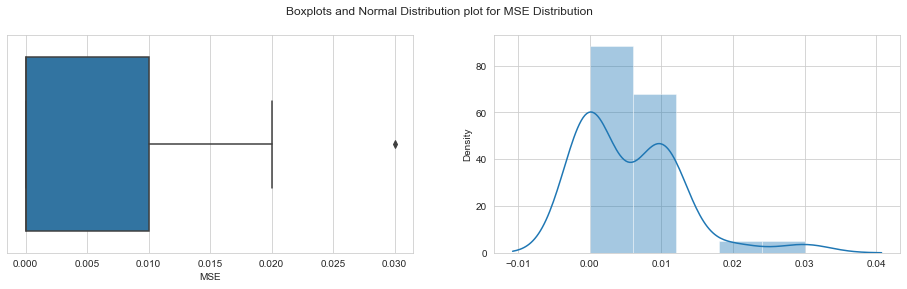

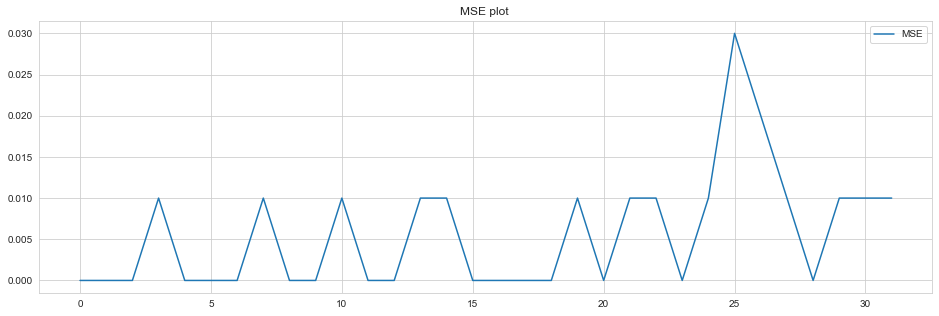


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 1
mean=0.004,median=0.0 ,max=0.02,min=0.0,variance=0.0


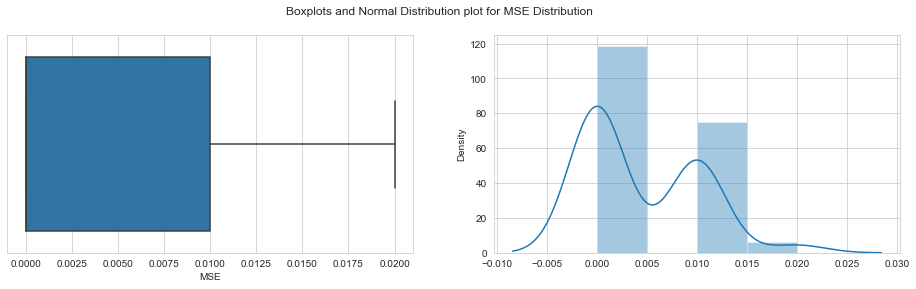

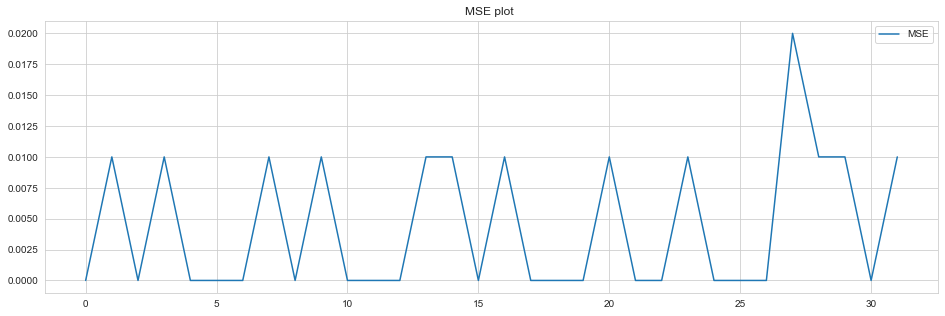


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 2
mean=0.007,median=0.01 ,max=0.02,min=0.0,variance=0.0


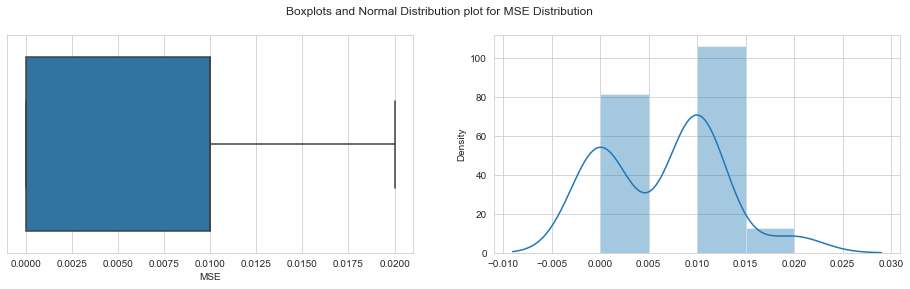

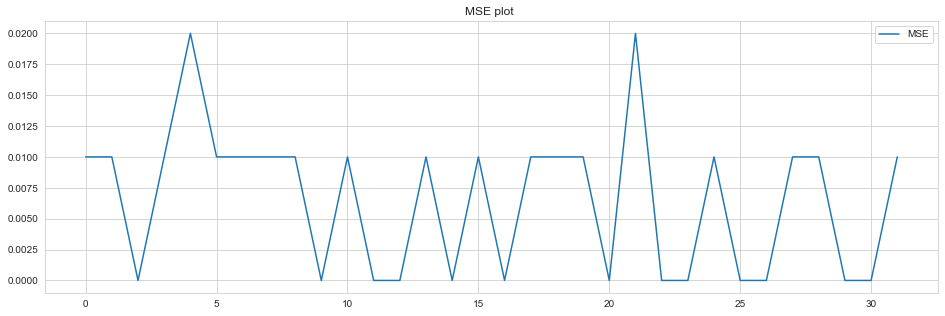


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 3
mean=0.004,median=0.0 ,max=0.01,min=0.0,variance=0.0


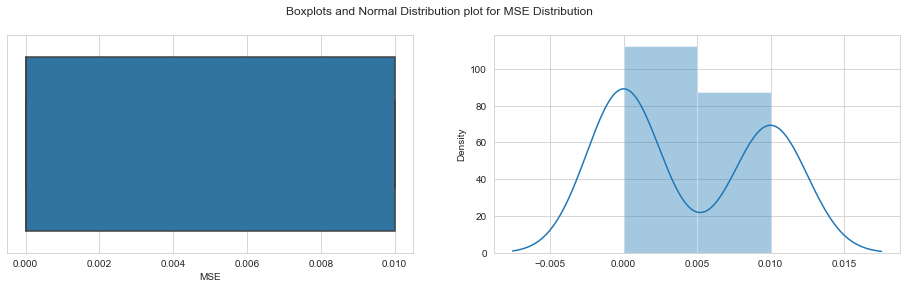

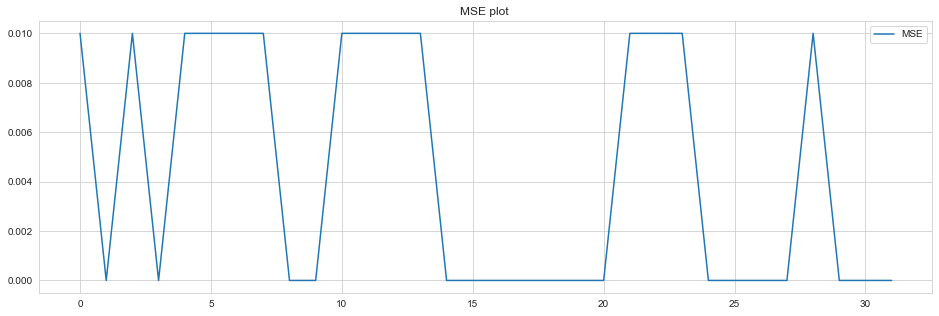


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 4
mean=0.003,median=0.0 ,max=0.01,min=0.0,variance=0.0


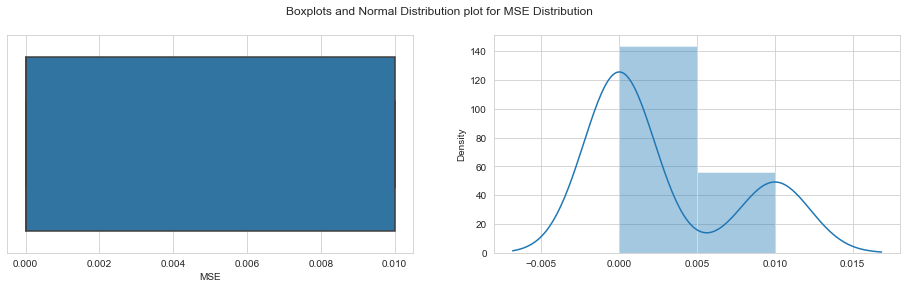

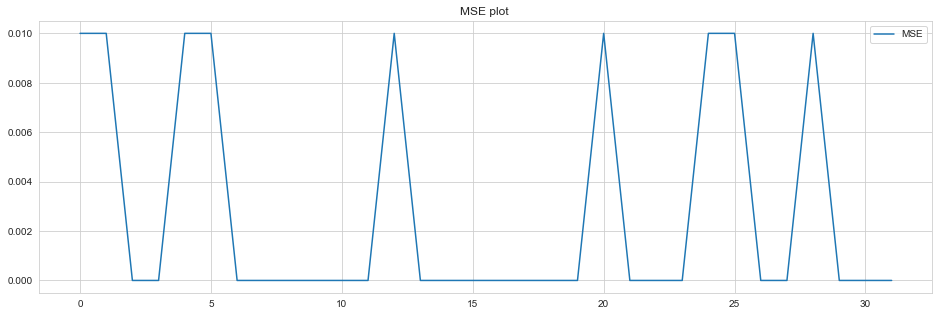


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 5
mean=0.001,median=0.0 ,max=0.01,min=0.0,variance=0.0


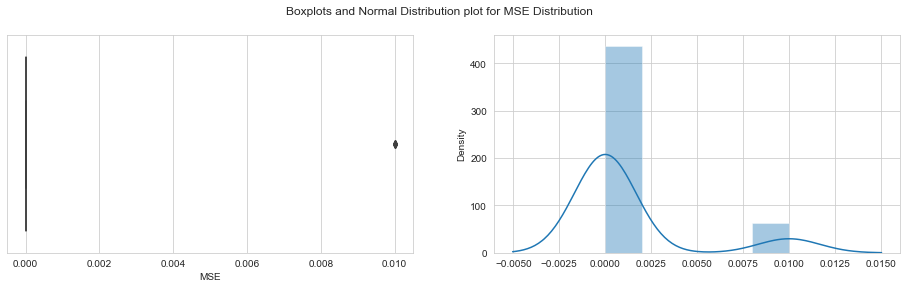

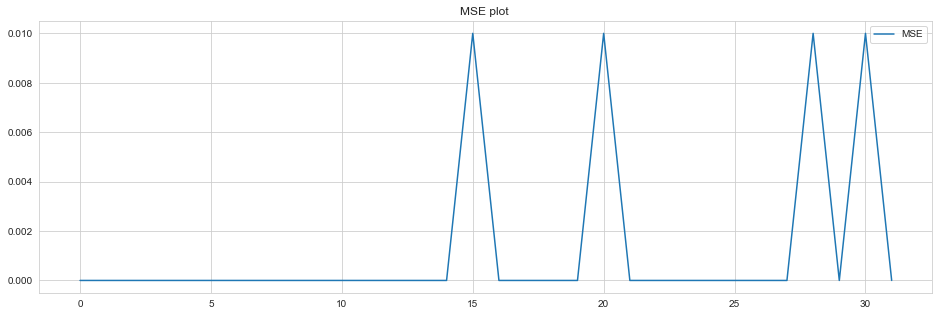


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 6
mean=0.003,median=0.0 ,max=0.01,min=0.0,variance=0.0


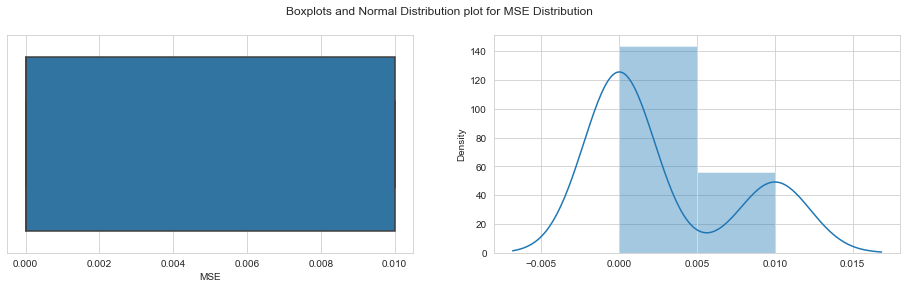

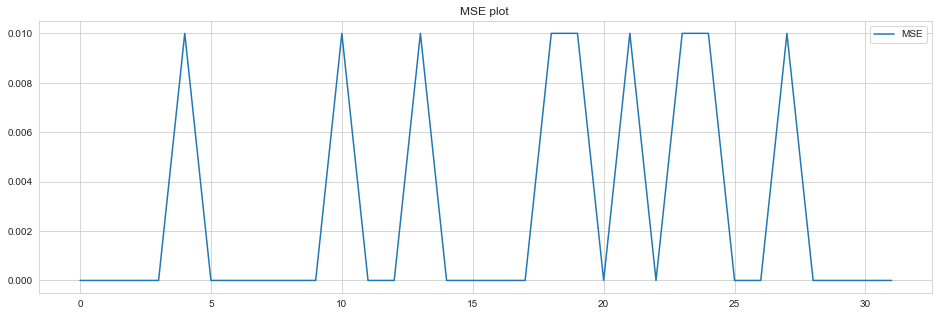


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 7
mean=0.005,median=0.0 ,max=0.02,min=0.0,variance=0.0


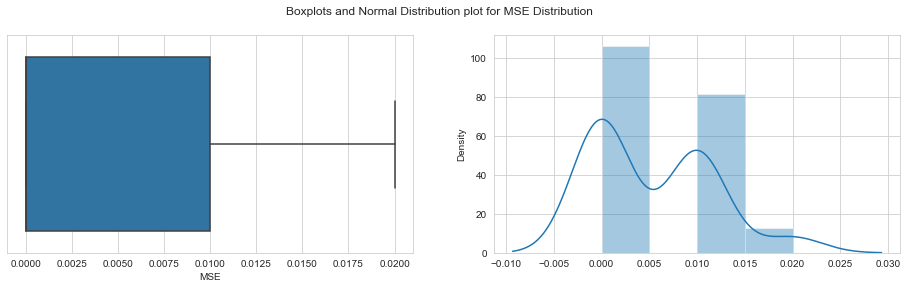

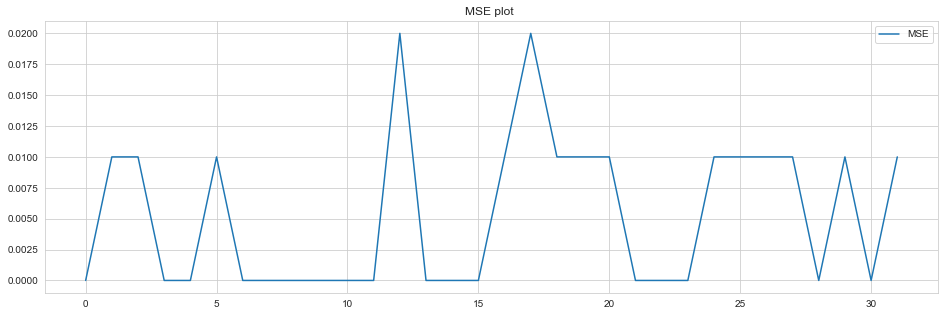


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 8
mean=0.01,median=0.01 ,max=0.02,min=0.0,variance=0.0


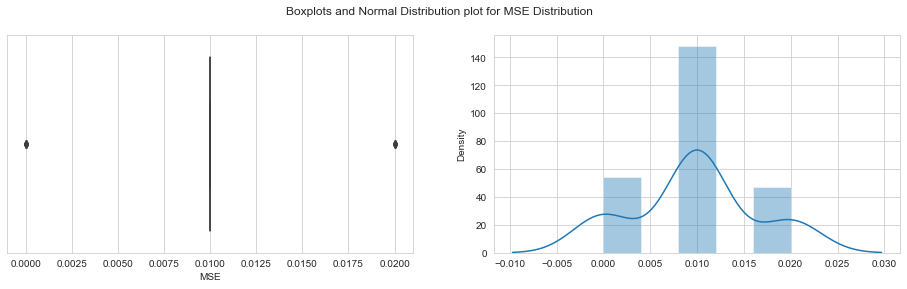

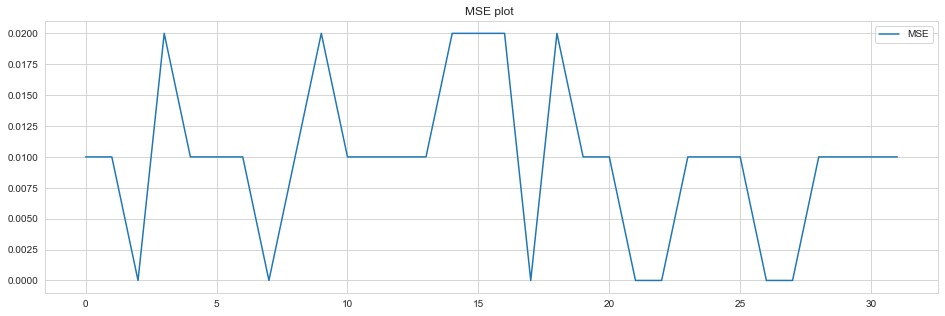


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 9
mean=0.006,median=0.0 ,max=0.04,min=0.0,variance=0.0


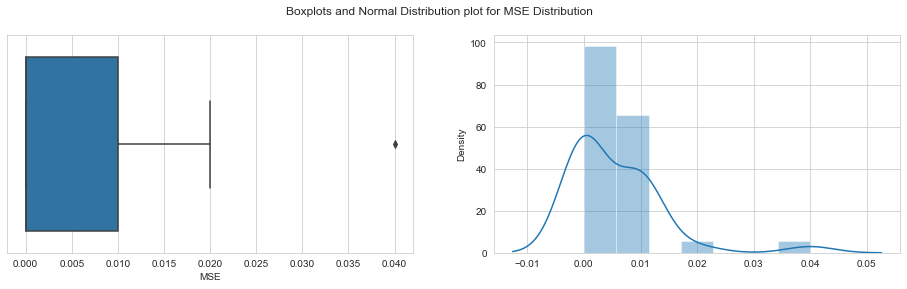

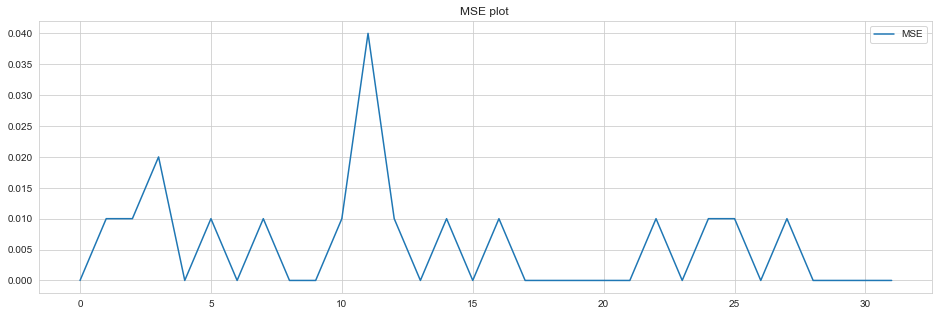


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 10
mean=0.002,median=0.0 ,max=0.02,min=0.0,variance=0.0


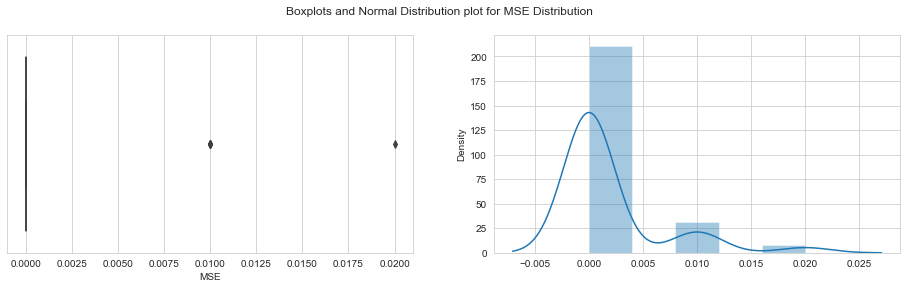

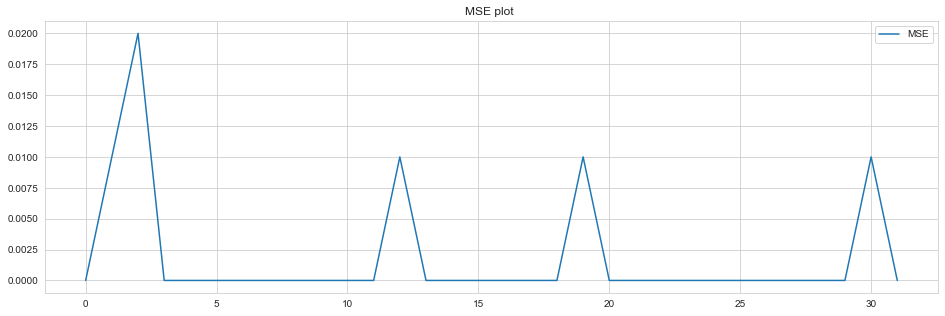


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 11
mean=0.002,median=0.0 ,max=0.01,min=0.0,variance=0.0


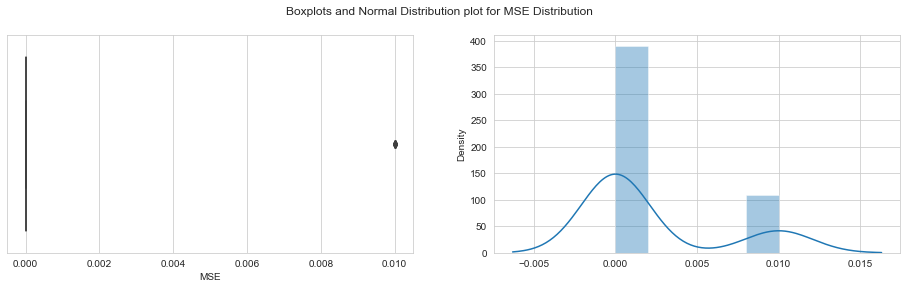

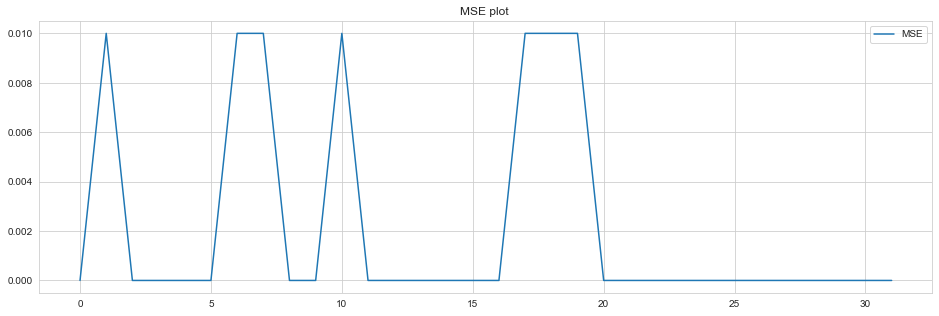


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 12
mean=0.005,median=0.005 ,max=0.01,min=0.0,variance=0.0


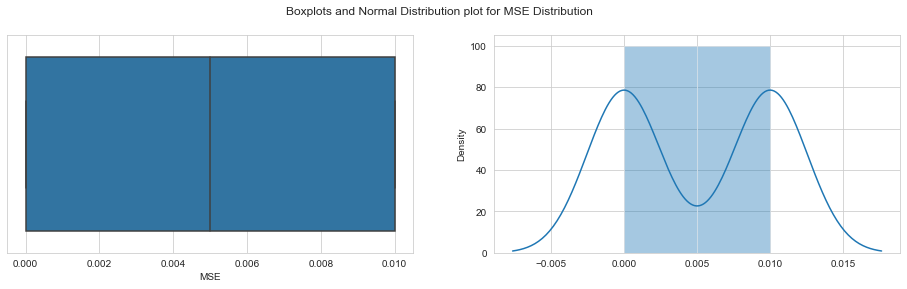

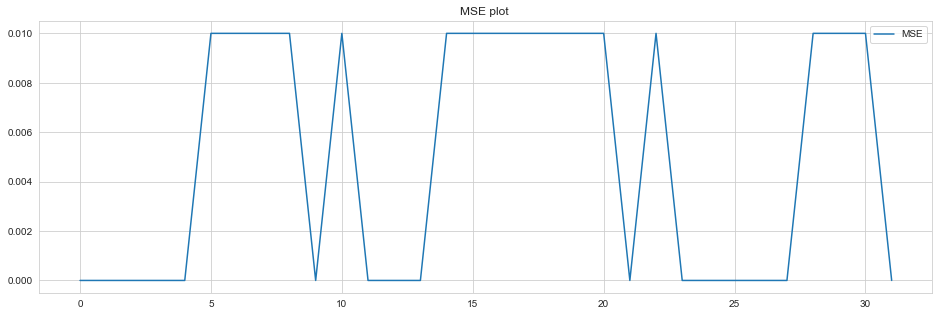


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 13
mean=0.002,median=0.0 ,max=0.01,min=0.0,variance=0.0


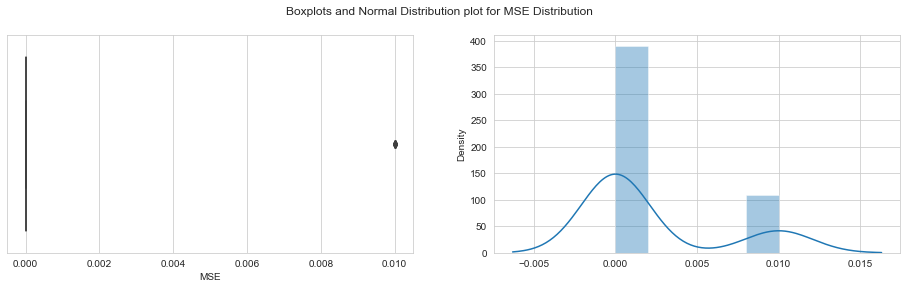

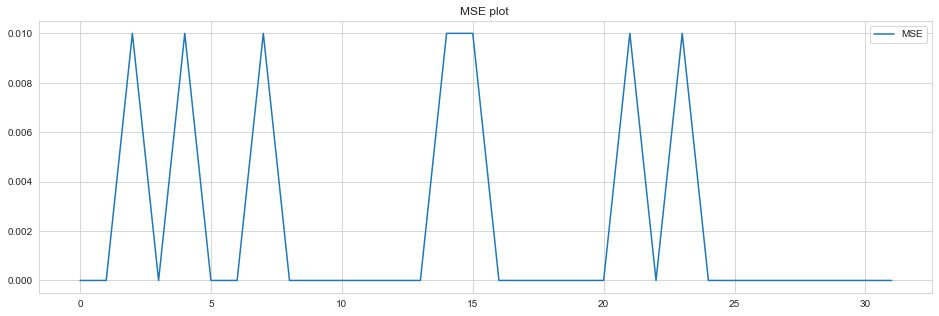


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 14
mean=0.005,median=0.0 ,max=0.02,min=0.0,variance=0.0


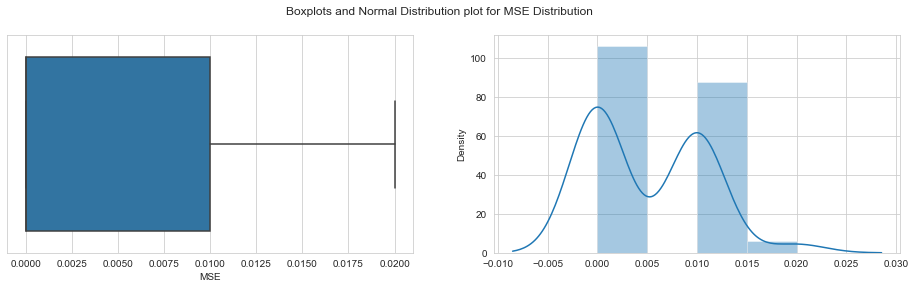

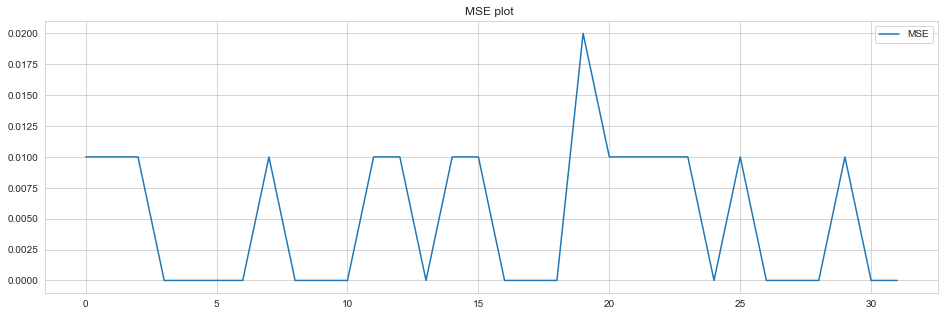


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 15
mean=0.011,median=0.01 ,max=0.03,min=0.0,variance=0.0


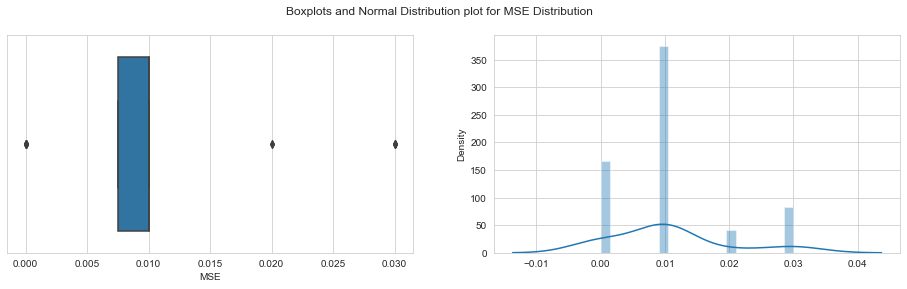

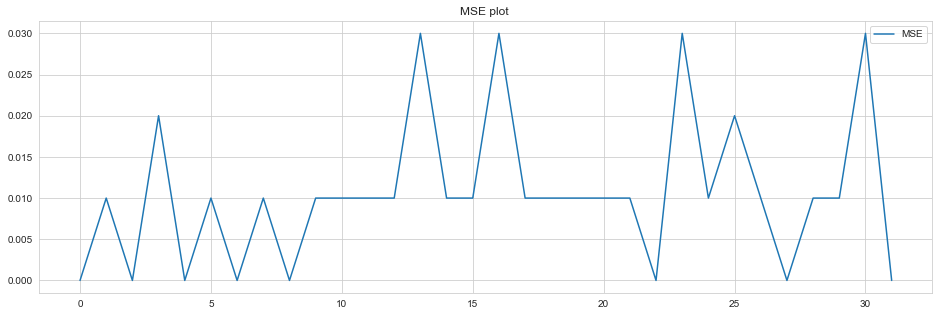


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 16
mean=0.004,median=0.0 ,max=0.04,min=0.0,variance=0.0


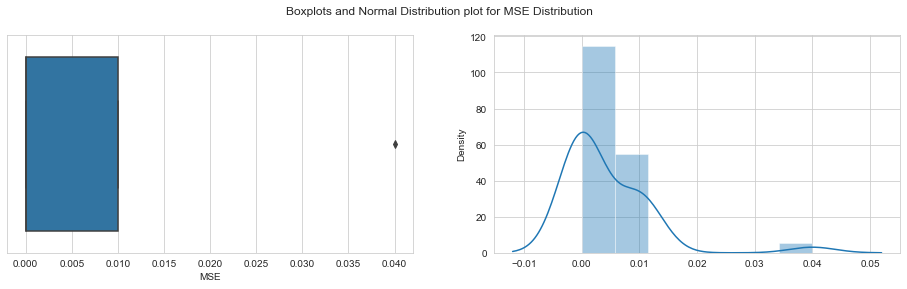

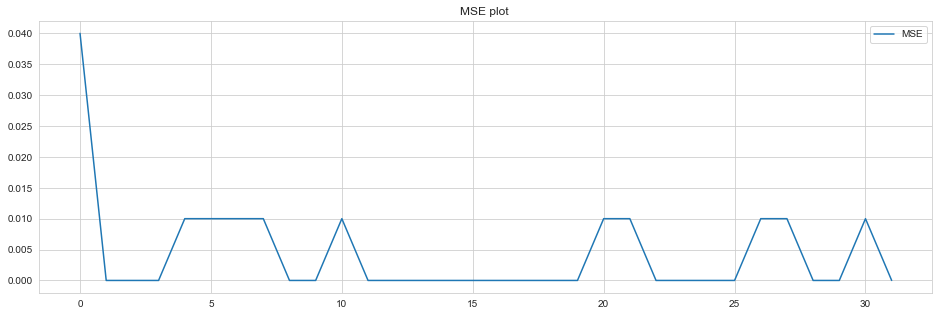


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 17
mean=0.004,median=0.0 ,max=0.02,min=0.0,variance=0.0


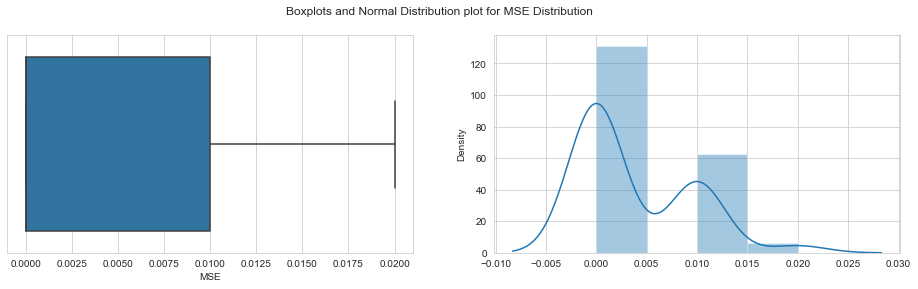

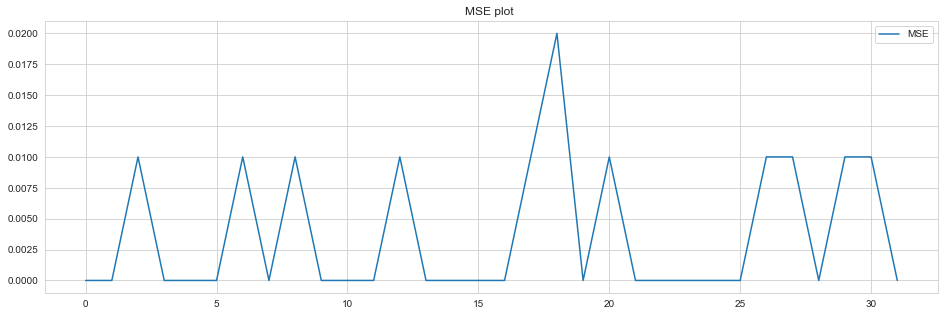


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 18
mean=0.004,median=0.0 ,max=0.01,min=0.0,variance=0.0


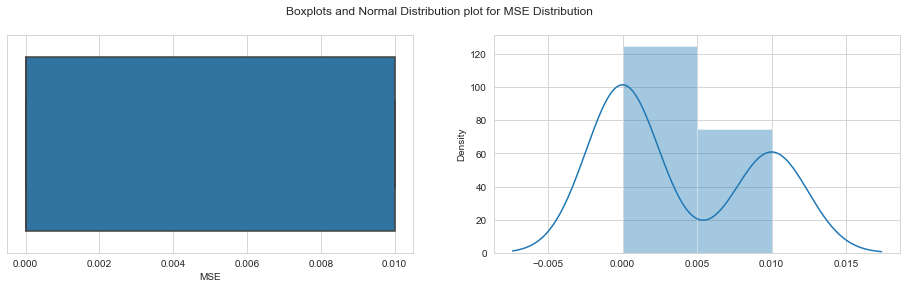

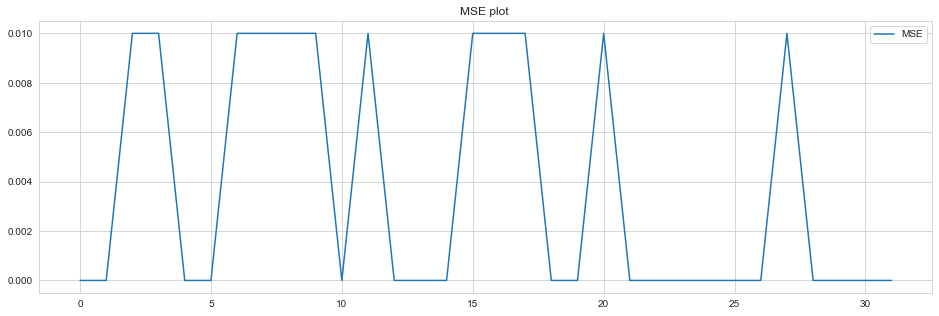


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 19
mean=0.002,median=0.0 ,max=0.01,min=0.0,variance=0.0


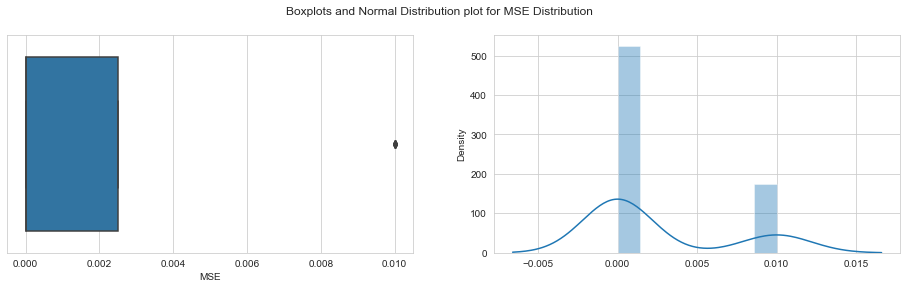

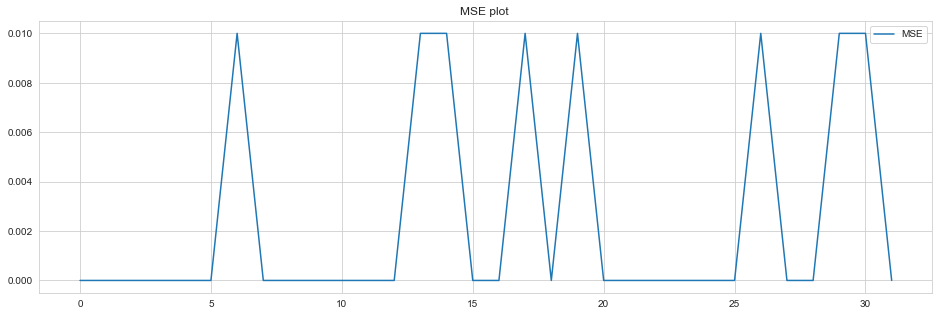


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 20
mean=0.003,median=0.0 ,max=0.01,min=0.0,variance=0.0


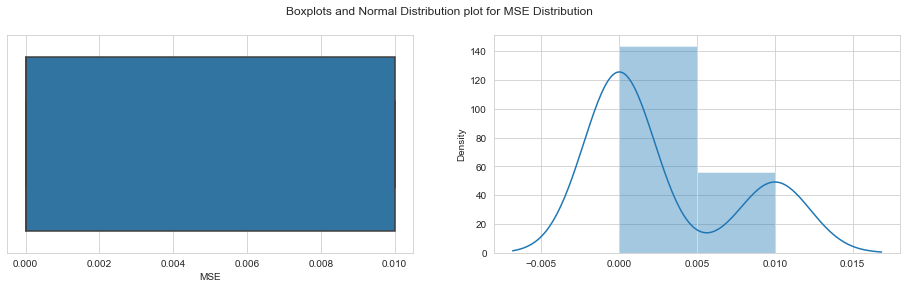

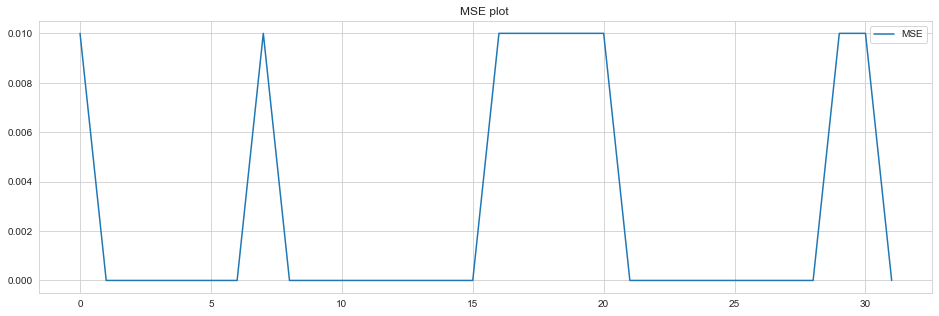


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 21
mean=0.006,median=0.01 ,max=0.01,min=0.0,variance=0.0


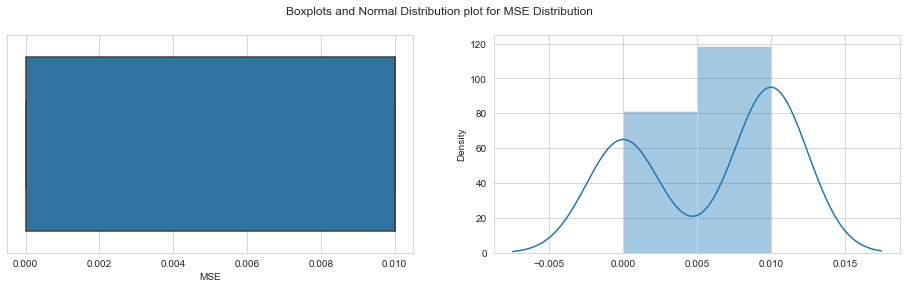

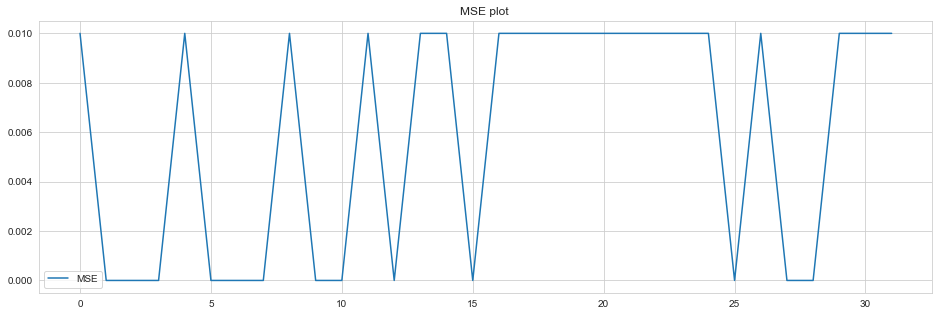


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 22
mean=0.006,median=0.01 ,max=0.01,min=0.0,variance=0.0


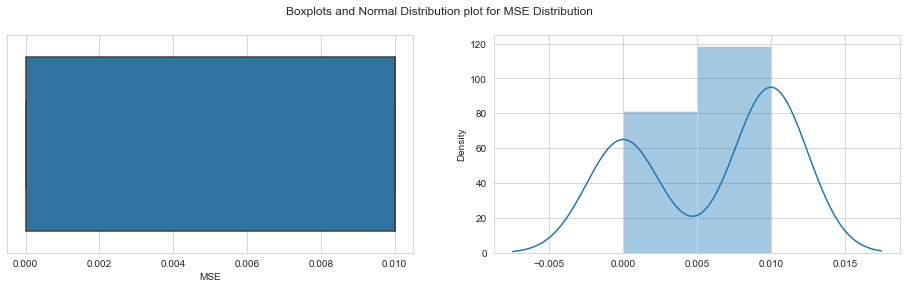

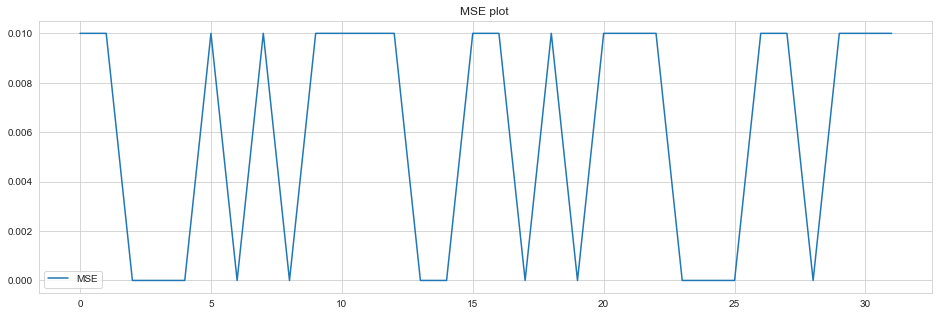


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 23
mean=0.01,median=0.01 ,max=0.04,min=0.0,variance=0.0


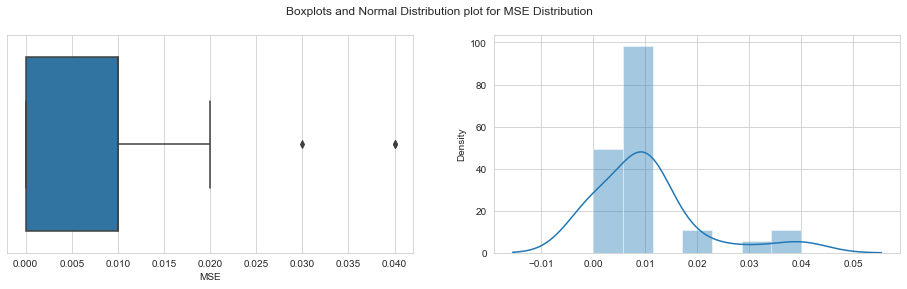

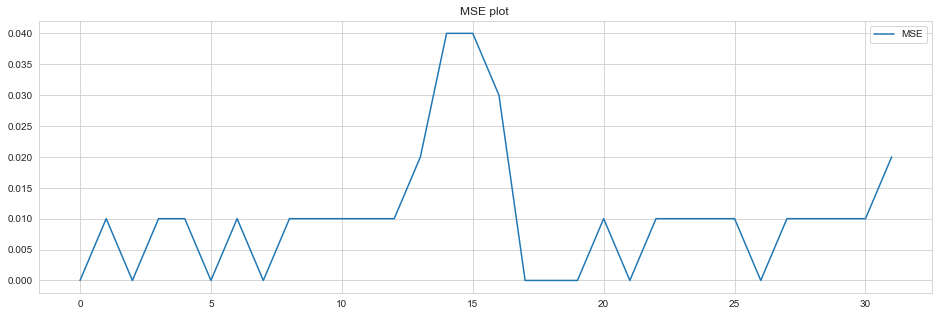


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 24
mean=0.005,median=0.0 ,max=0.04,min=0.0,variance=0.0


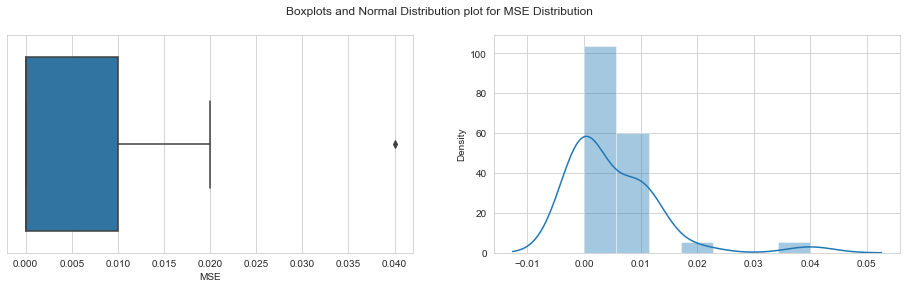

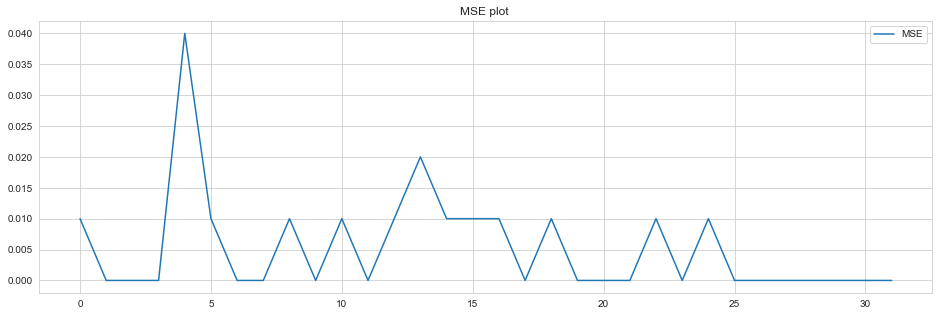


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 25
mean=0.004,median=0.0 ,max=0.01,min=0.0,variance=0.0


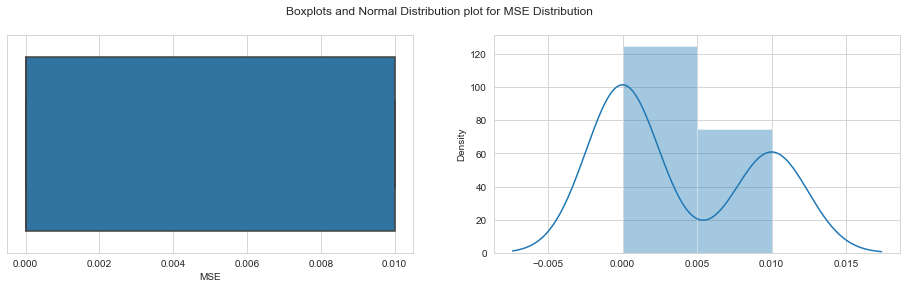

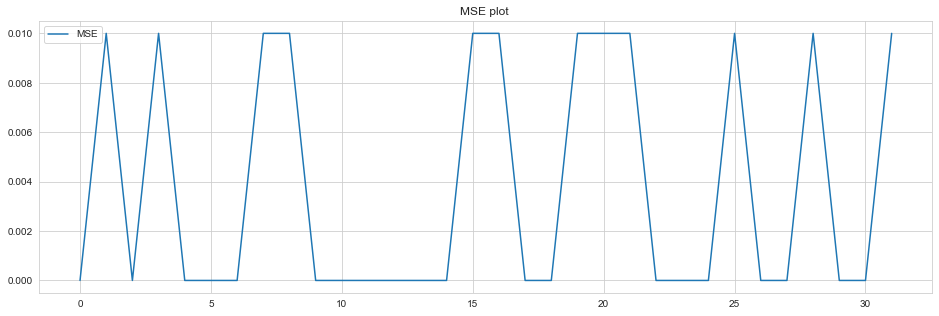


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 26
mean=0.002,median=0.0 ,max=0.01,min=0.0,variance=0.0


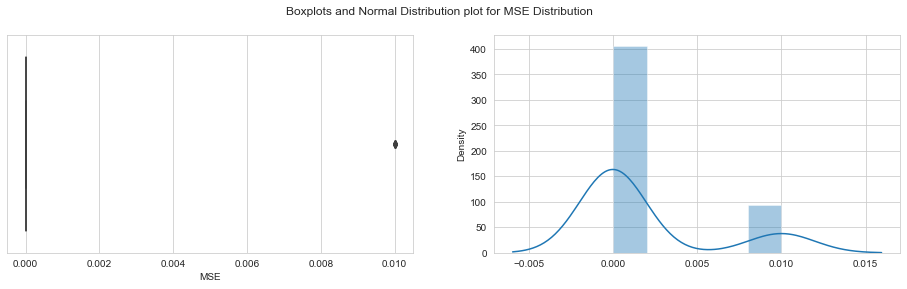

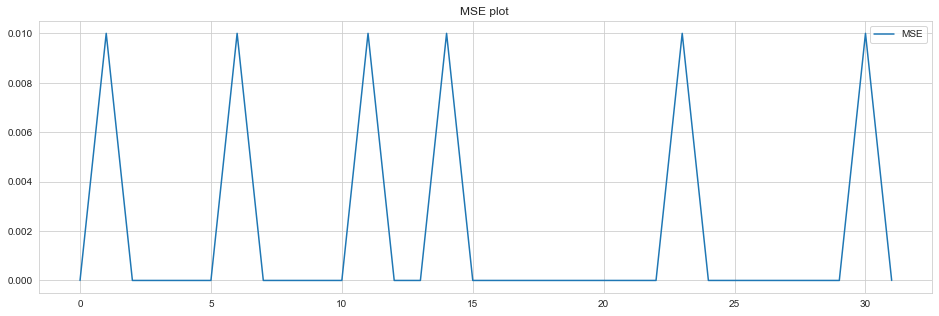


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 27
mean=0.005,median=0.0 ,max=0.03,min=0.0,variance=0.0


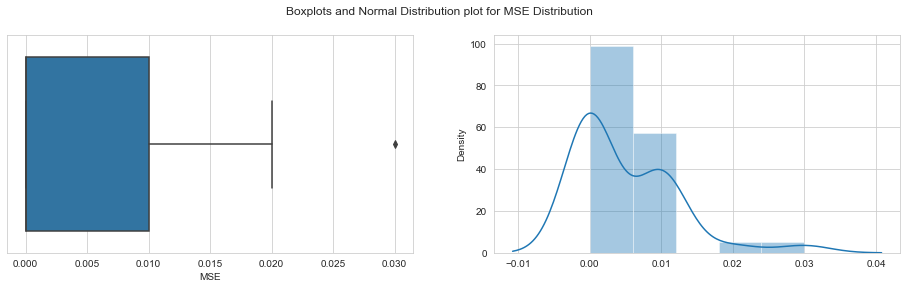

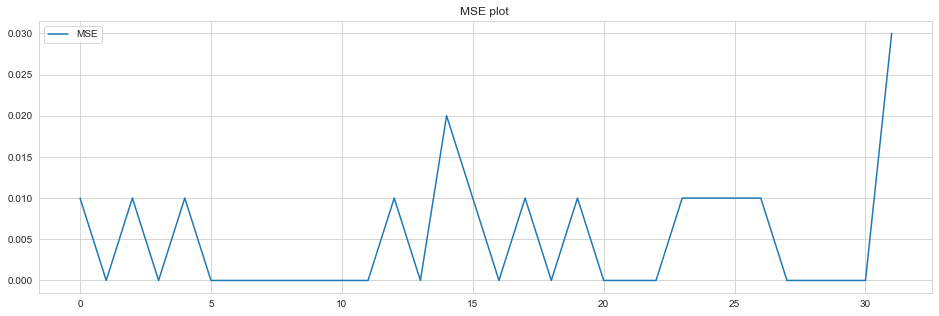


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 28
mean=0.005,median=0.0 ,max=0.02,min=0.0,variance=0.0


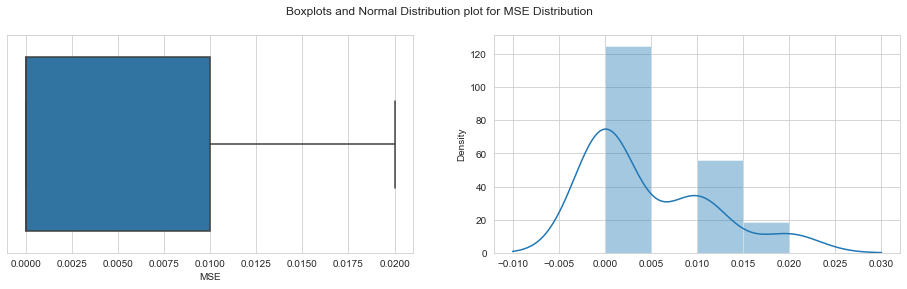

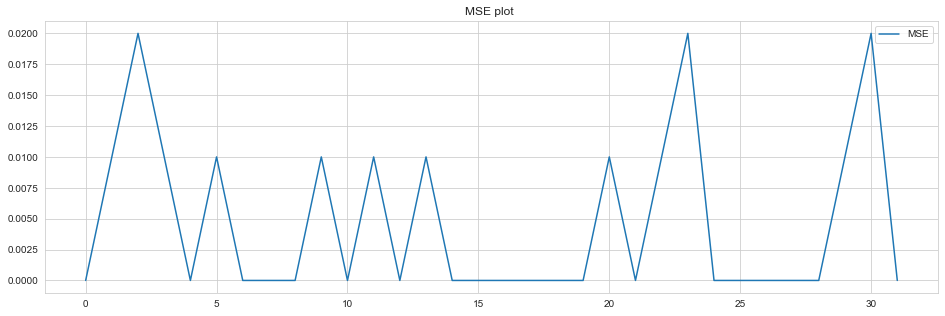


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 29
mean=0.004,median=0.0 ,max=0.01,min=0.0,variance=0.0


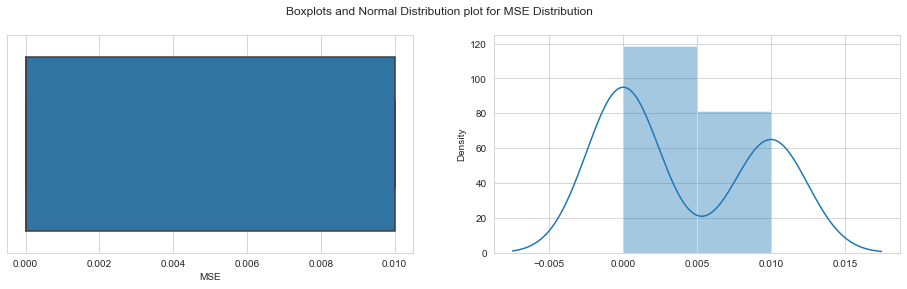

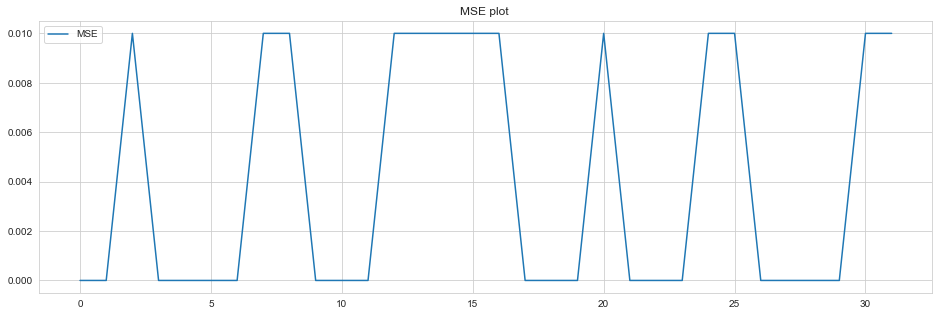


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 30
mean=0.003,median=0.0 ,max=0.02,min=0.0,variance=0.0


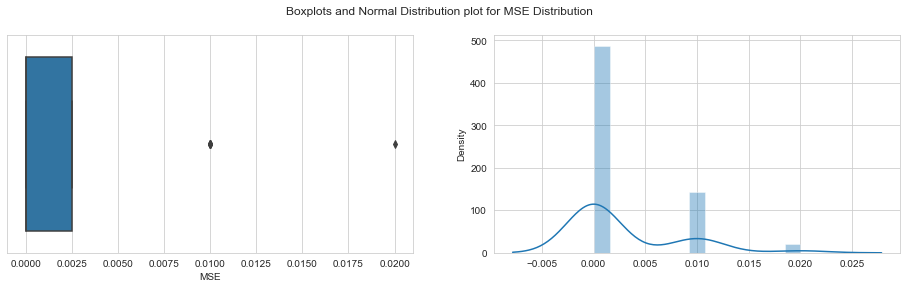

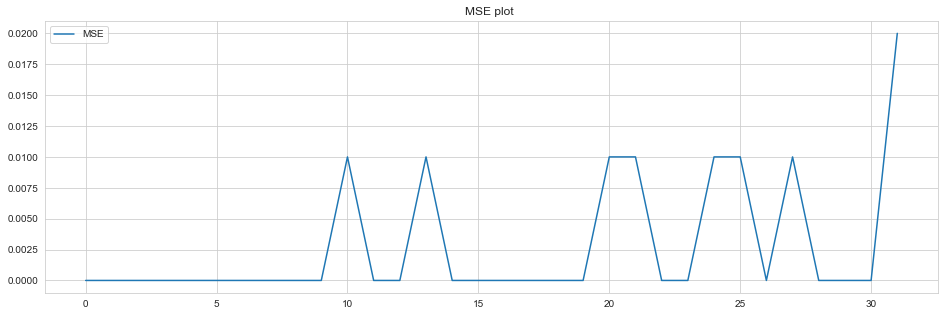


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 31
mean=0.003,median=0.0 ,max=0.02,min=0.0,variance=0.0


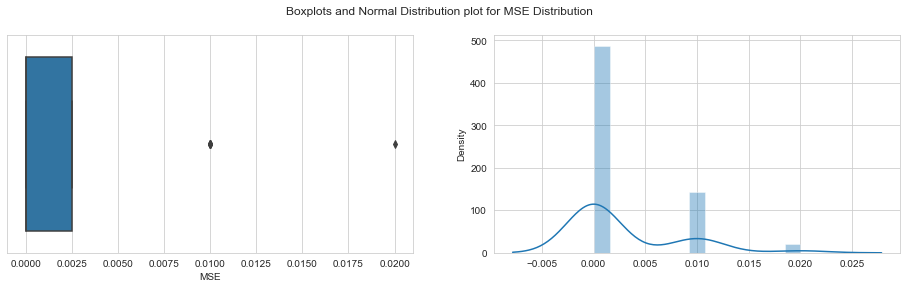

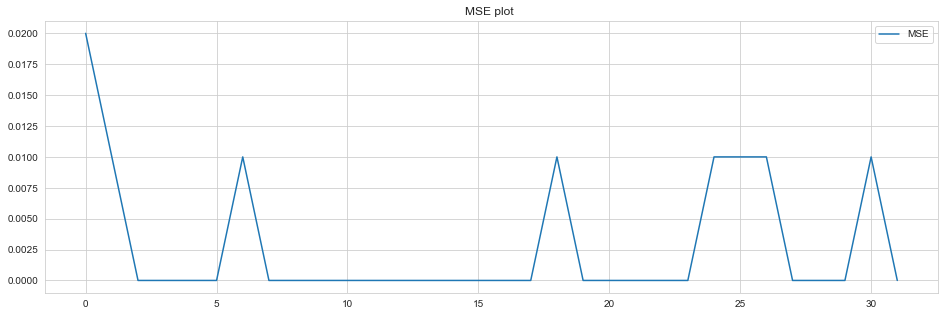


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 32
mean=0.003,median=0.0 ,max=0.02,min=0.0,variance=0.0


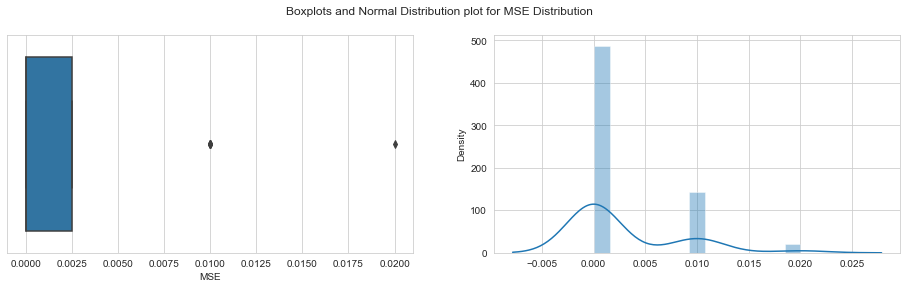

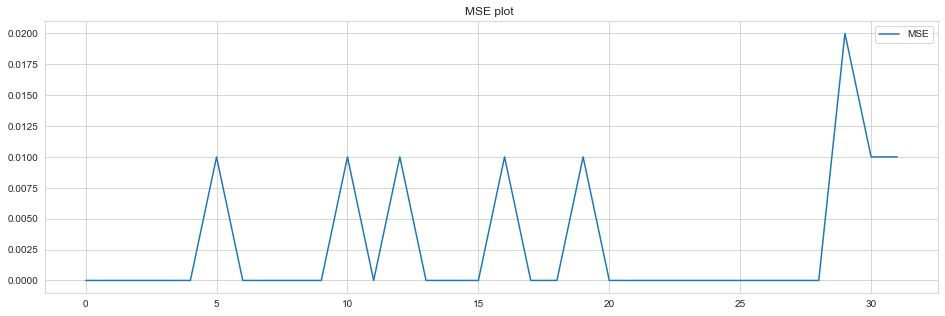


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 33
mean=0.004,median=0.0 ,max=0.02,min=0.0,variance=0.0


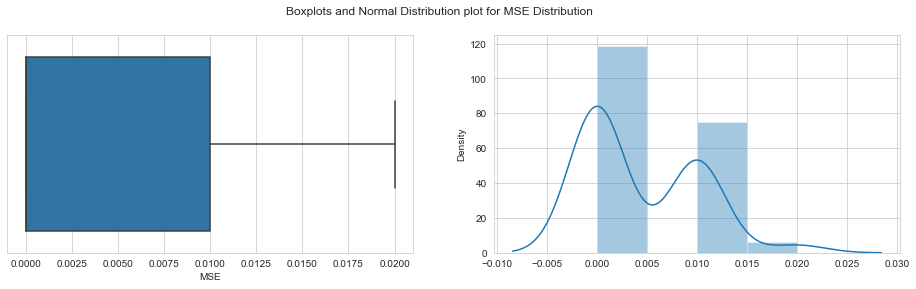

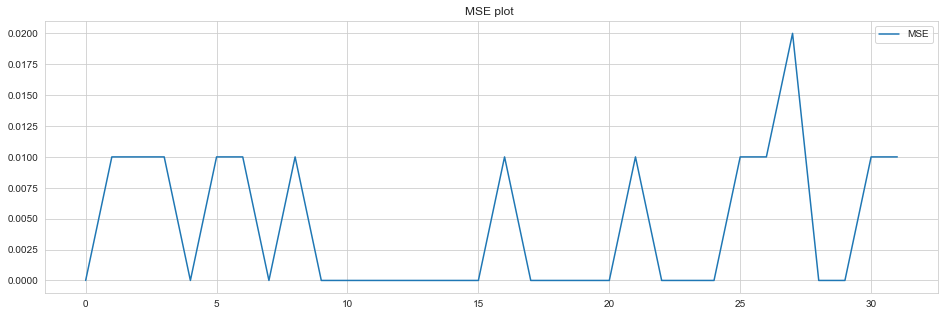


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 34
mean=0.004,median=0.0 ,max=0.01,min=0.0,variance=0.0


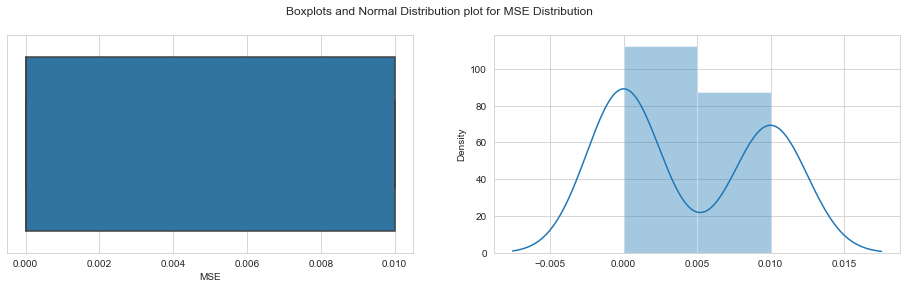

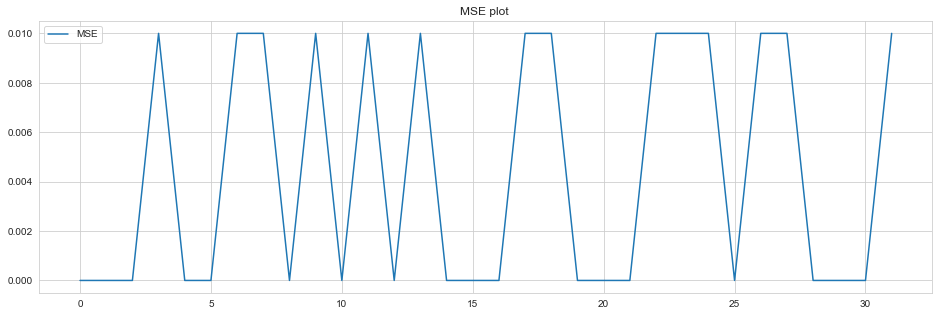


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 35
mean=0.004,median=0.0 ,max=0.01,min=0.0,variance=0.0


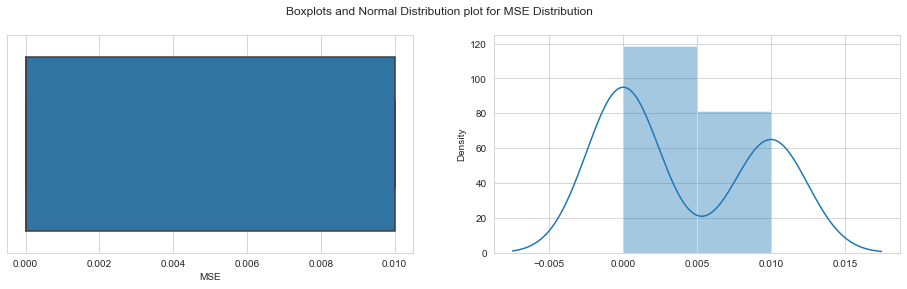

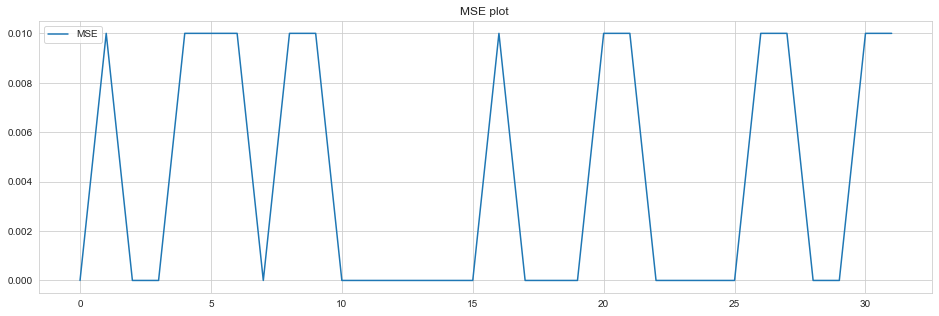


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 36
mean=0.011,median=0.01 ,max=0.06,min=0.0,variance=0.0


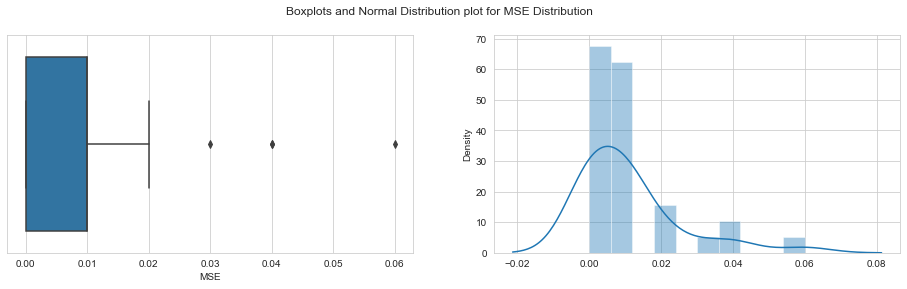

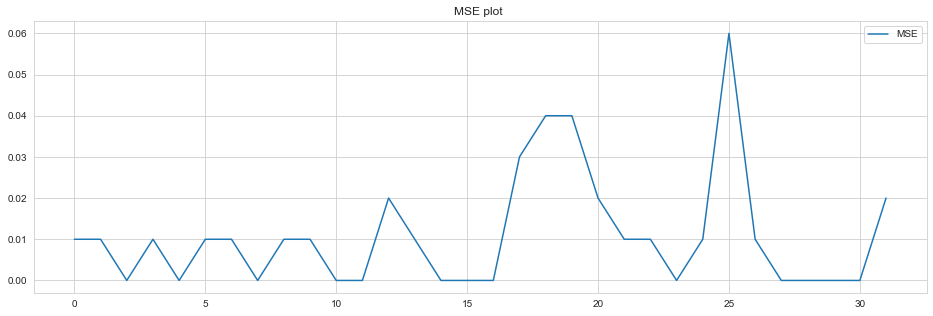


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 37
mean=0.003,median=0.0 ,max=0.01,min=0.0,variance=0.0


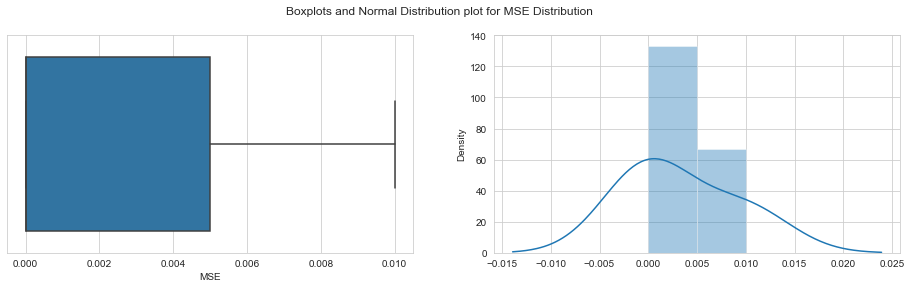

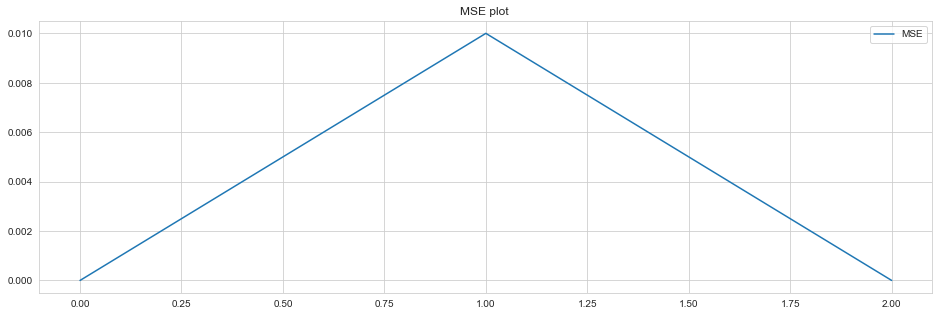


Shapiro_Wilk Test

Anderson_Darling Test


In [631]:
batch_avg_mse_neg_en_neg,batch_mse_values_neg_en_neg=check_all_batch_normality(batches_neg,encoder_neg_class,32)

In [632]:
batch_avg_mse_neg_en_neg;

In [633]:
def compute_instance_threshold_firstN_batches(batch_avg_mse_values,N):
    zscore_list=[]
    #value_list=[]
    for k in range(0,N):
        value_list=batch_avg_mse_values[k]
         #Z_SCORE
        mean=np.mean(value_list)
        sigma=np.std(value_list)
        thres_zscore=(mean+3*sigma).round(4)
        zscore_list.append(thres_zscore)
        #print (value_list)
        #print(zscore_list)
    return (np.mean(zscore_list).round(4)) , zscore_list  

In [634]:
instance_thresh_neg,zscore_list_neg=compute_instance_threshold_firstN_batches(batch_mse_values_neg_en_neg,10)

In [635]:
instance_thresh_neg

0.0181

In [636]:
## computes loss threshold uisng IQR as well as ZScore from first test batch 
def compute_loss_threshold_testdata(threshold_batch):
    #val_loss=history['val_loss']
    ## Quartile Method 
    Q1=np.quantile(threshold_batch,0.25)
    Q3=np.quantile(threshold_batch,0.75)
    IQR=Q3-Q1
    thres_iqr=(Q3+1.5*IQR).round(4)
    #Z_SCORE
    mean=np.mean(threshold_batch)
    sigma=np.std(threshold_batch)
    thres_zscore=(mean+3*sigma).round(4)
    
    return thres_iqr ,thres_zscore

In [637]:
## computes loss threshold uisng IQR as well as ZScore from first test batch 
def compute_batch_threshold_testdata(batch_avg_mse):
    #val_loss=history['val_loss']
    ## Quartile Method 
    Q1=np.quantile(batch_avg_mse,0.25)
    Q3=np.quantile(batch_avg_mse,0.75)
    IQR=Q3-Q1
    thres_iqr=(Q3 + 1.5*IQR).round(4)
    #Z_SCORE
    mean=np.mean(batch_avg_mse)
    sigma=np.std(batch_avg_mse)
    thres_zscore=(mean+3*sigma).round(4)
    thresh_max=np.round((np.max(batch_avg_mse)),3)
    return thres_iqr, thres_zscore ,thresh_max

In [638]:
thres_iqr_batch_neg, thres_zscore_batch_neg ,thresh_max_batch_neg=compute_batch_threshold_testdata(batch_avg_mse_neg_en_neg)

In [639]:
thres_zscore_batch_neg

0.0119

In [640]:
def threshold_exceed_count(batch_mse_values, thr):
    exceed_count={}
    for key in batch_mse_values.keys():
        count=0
        list=batch_mse_values[key]
        for a in range(0,len(list)):
            if list[a]>thr:
                count+=1
        exceed_count[key]=count 
    values = exceed_count.values()
    total = sum(values)
    return exceed_count,total

In [641]:
# Counts the MSE values exceeding threshold in each batch 
exceed_count_neg_en_neg,total_neg_en_neg=threshold_exceed_count(batch_mse_values_neg_en_neg,instance_thresh_neg)

In [642]:
exceed_list_neg_en_neg=[]
for key in exceed_count_neg_en_neg.keys():
    exceed_list_neg_en_neg.append(exceed_count_neg_en_neg[key])

mean=0.895,median=0.0 ,max=7,min=0,variance=2.357


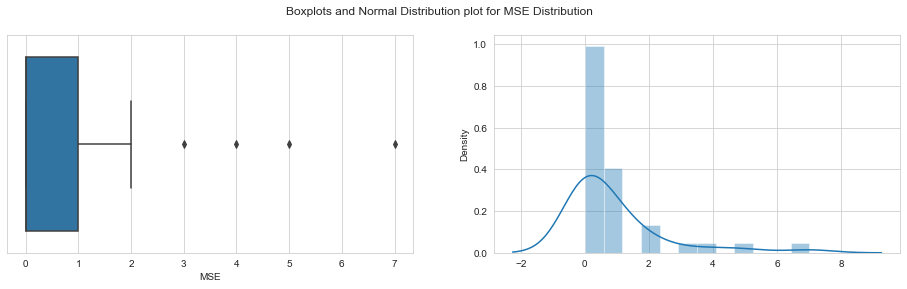

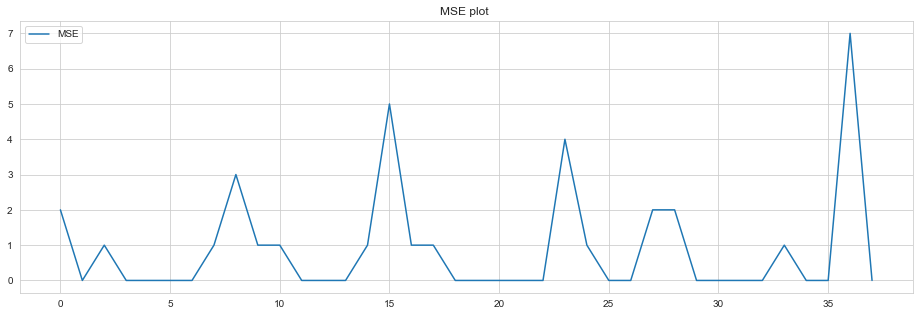

In [643]:
plot_results(exceed_list_neg_en_neg)

In [644]:
count_thresh_neg=np.max(exceed_list_neg_en_neg)

In [645]:
count_thresh_neg

7

## Positive AE

In [646]:
predictions_pos=mse_predictions(test_pos_class,encoder_pos_class)

mean=0.005,median=0.0 ,max=0.04,min=0.0,variance=0.0


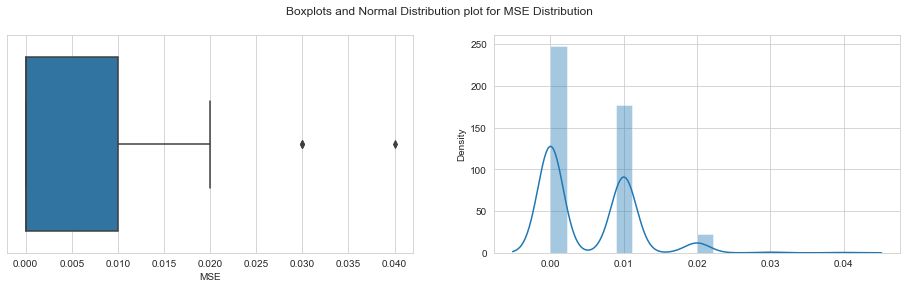

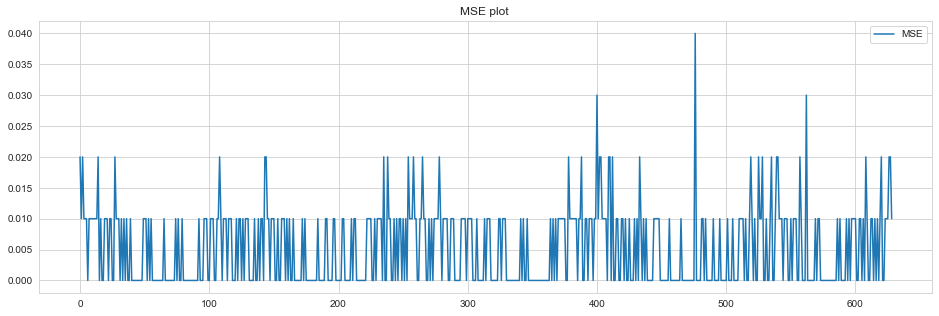

In [647]:
plot_results(predictions_pos)

In [648]:
batches_pos, batch_size=make_batches(test_pos_class)


 ********************
Batch: 0
mean=0.009,median=0.01 ,max=0.02,min=0.0,variance=0.0


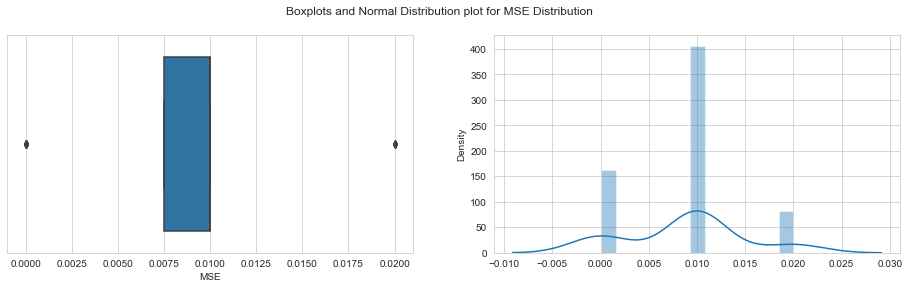

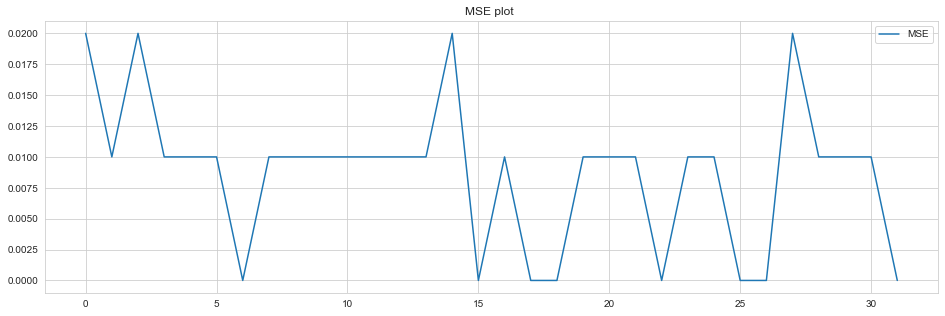


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 1
mean=0.003,median=0.0 ,max=0.01,min=0.0,variance=0.0


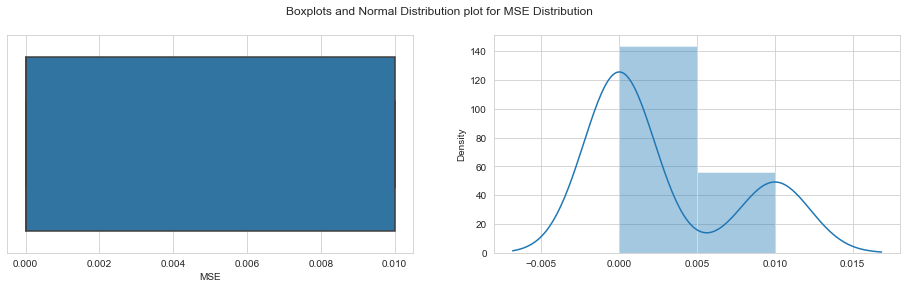

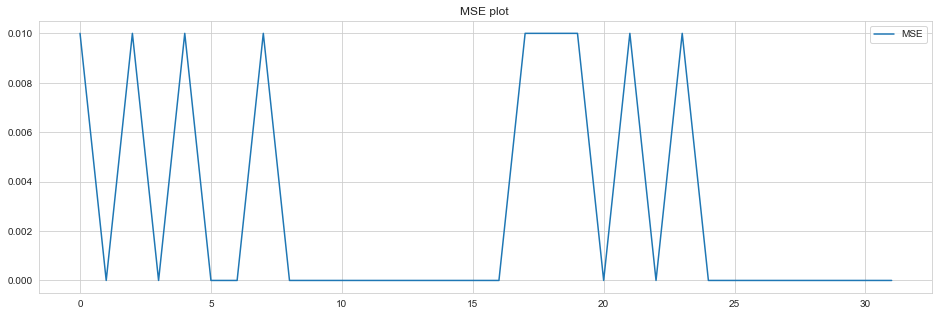


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 2
mean=0.002,median=0.0 ,max=0.01,min=0.0,variance=0.0


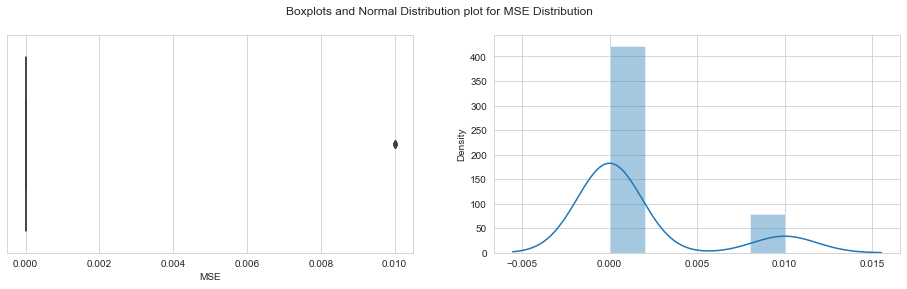

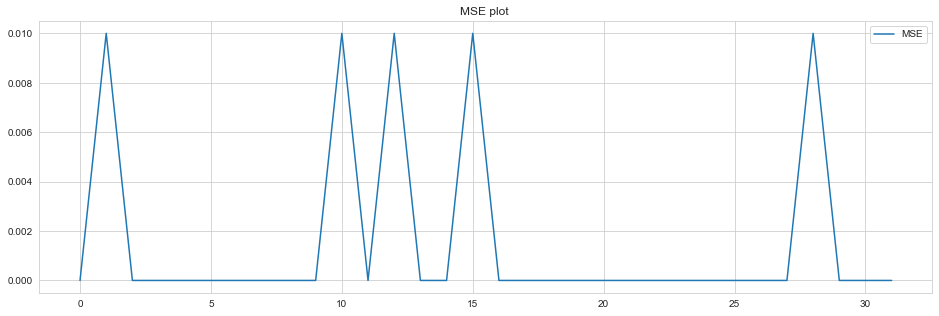


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 3
mean=0.007,median=0.01 ,max=0.02,min=0.0,variance=0.0


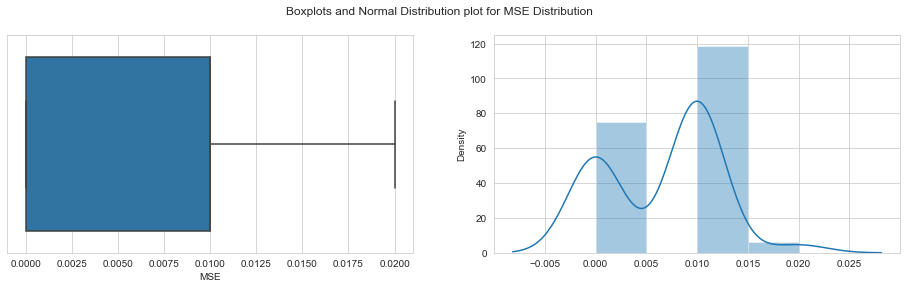

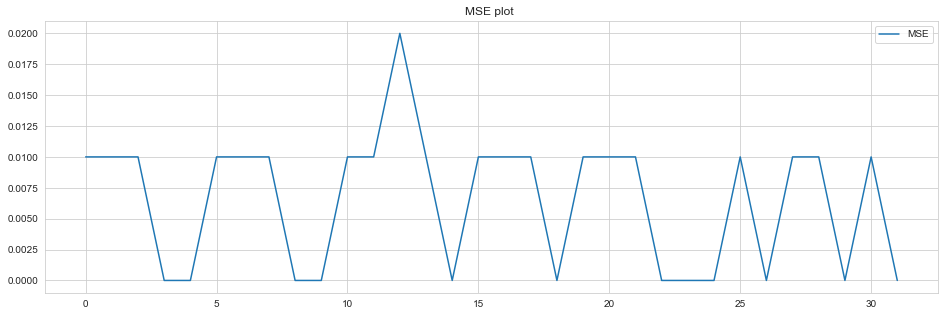


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 4
mean=0.006,median=0.01 ,max=0.02,min=0.0,variance=0.0


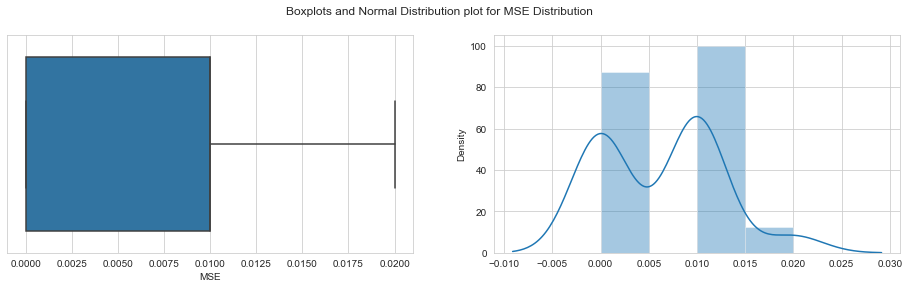

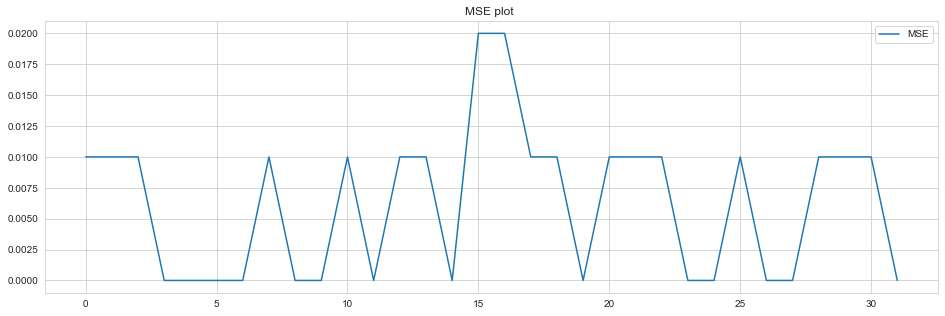


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 5
mean=0.002,median=0.0 ,max=0.01,min=0.0,variance=0.0


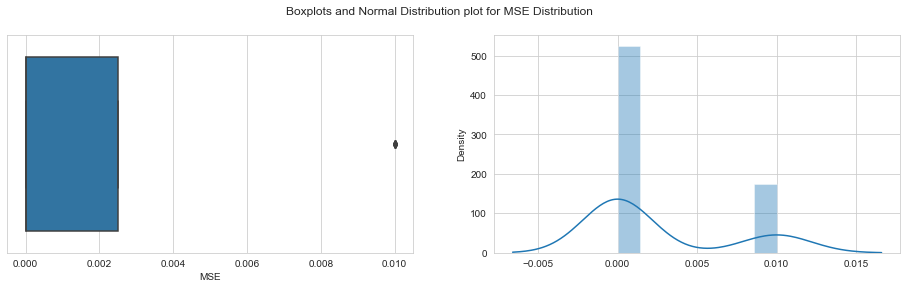

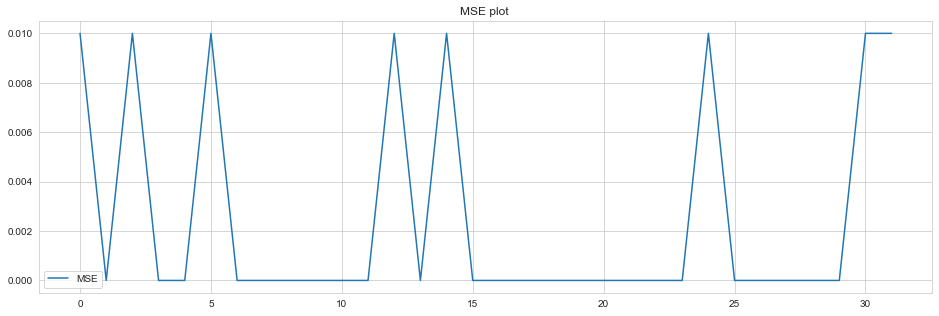


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 6
mean=0.003,median=0.0 ,max=0.01,min=0.0,variance=0.0


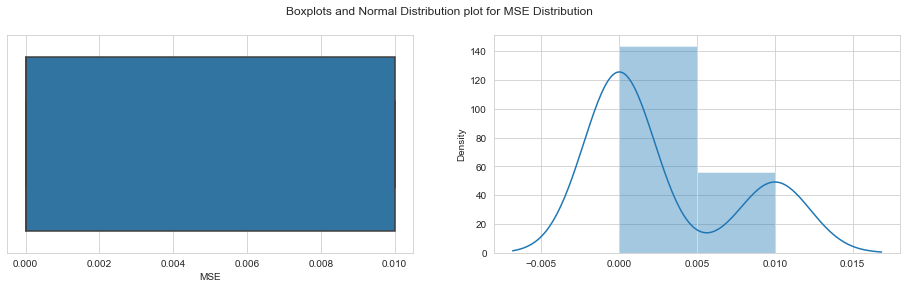

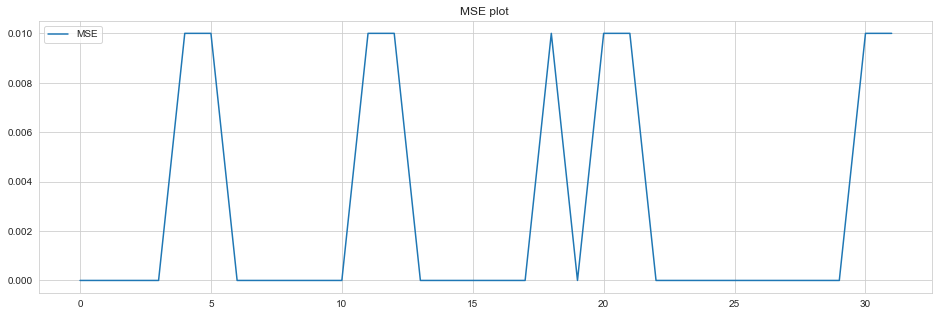


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 7
mean=0.007,median=0.01 ,max=0.02,min=0.0,variance=0.0


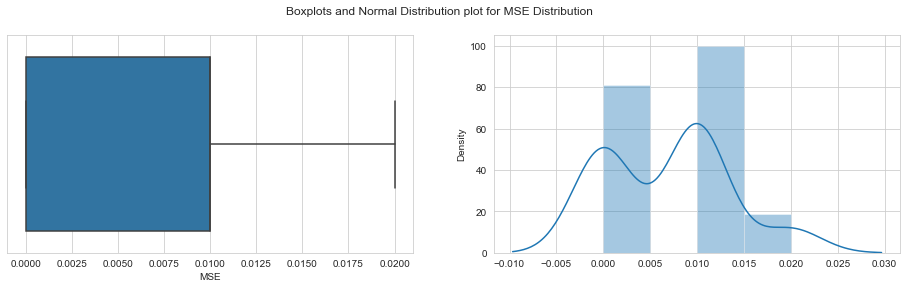

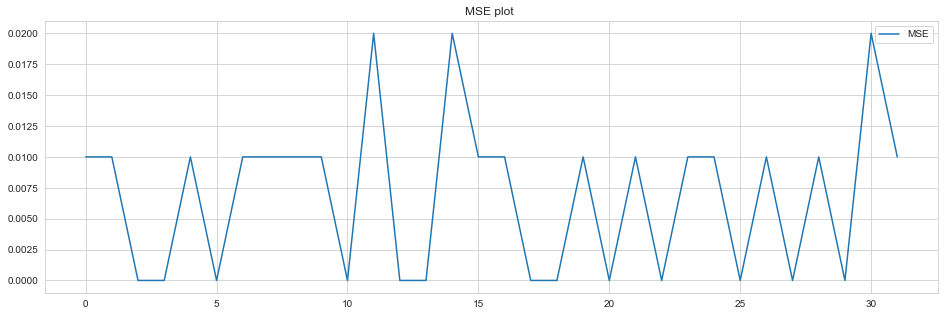


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 8
mean=0.008,median=0.01 ,max=0.02,min=0.0,variance=0.0


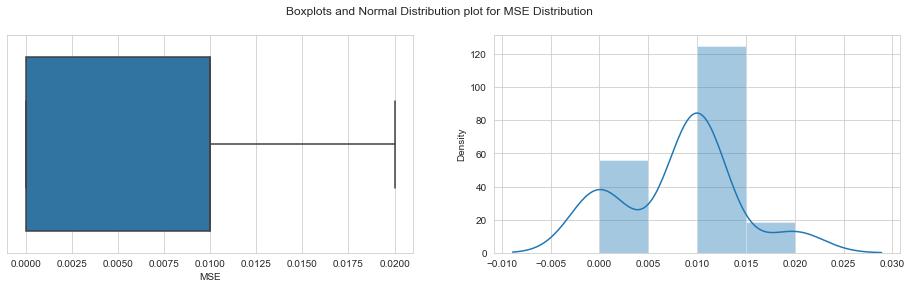

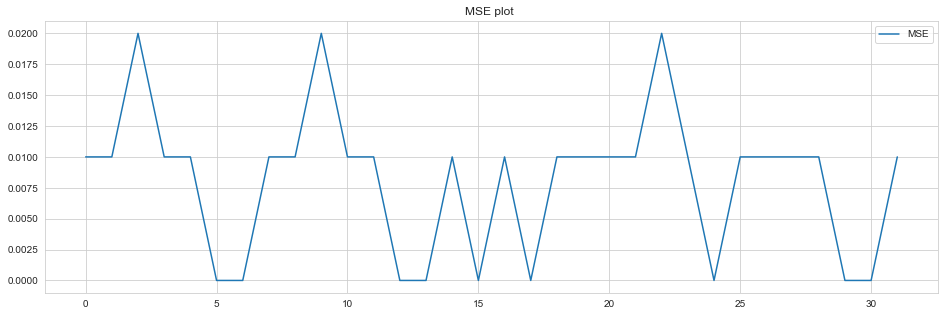


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 9
mean=0.005,median=0.0 ,max=0.01,min=0.0,variance=0.0


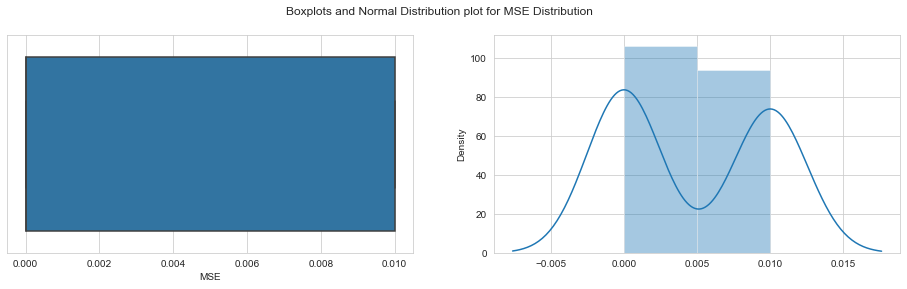

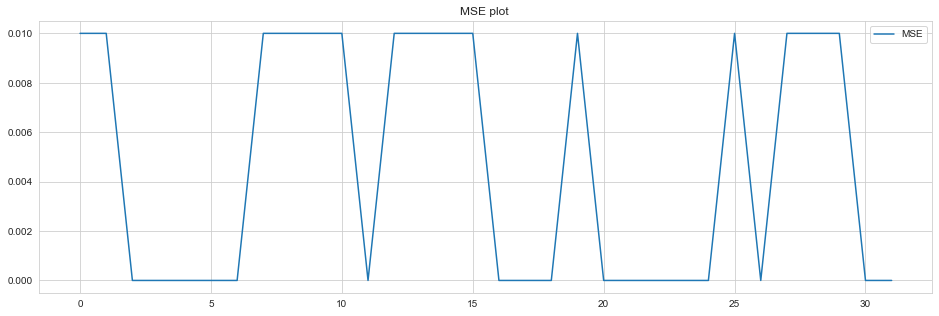


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 10
mean=0.002,median=0.0 ,max=0.01,min=0.0,variance=0.0


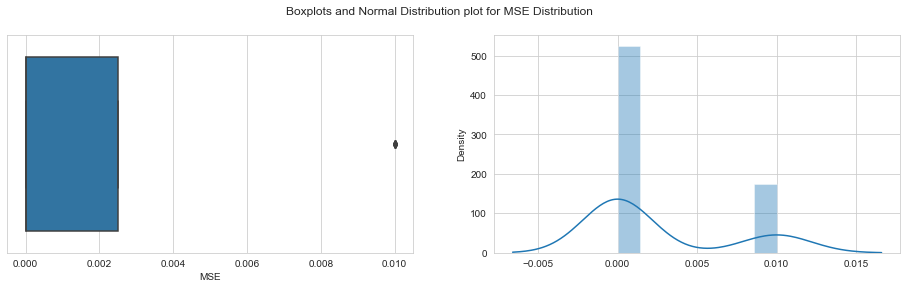

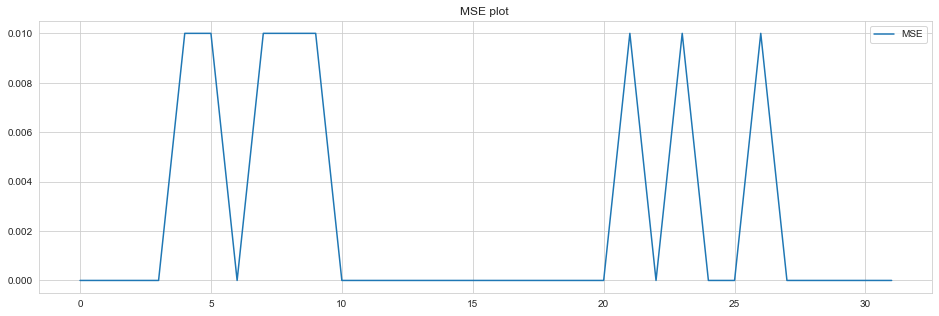


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 11
mean=0.005,median=0.0 ,max=0.02,min=0.0,variance=0.0


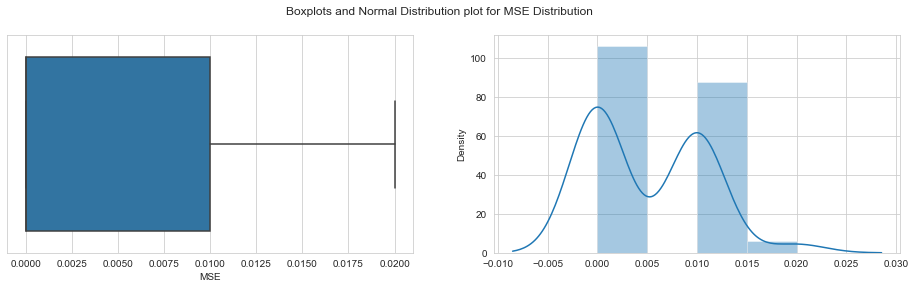

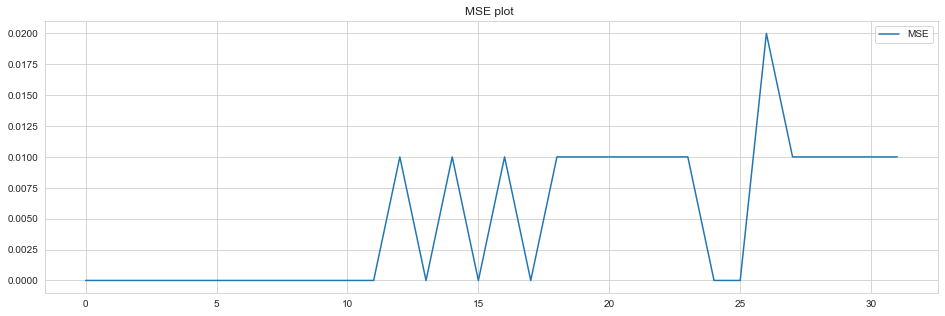


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 12
mean=0.01,median=0.01 ,max=0.03,min=0.0,variance=0.0


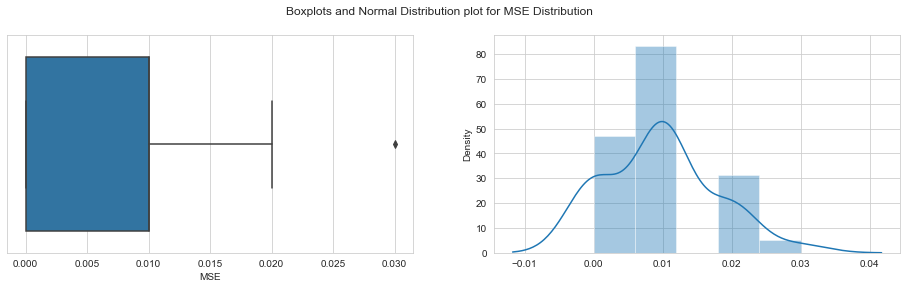

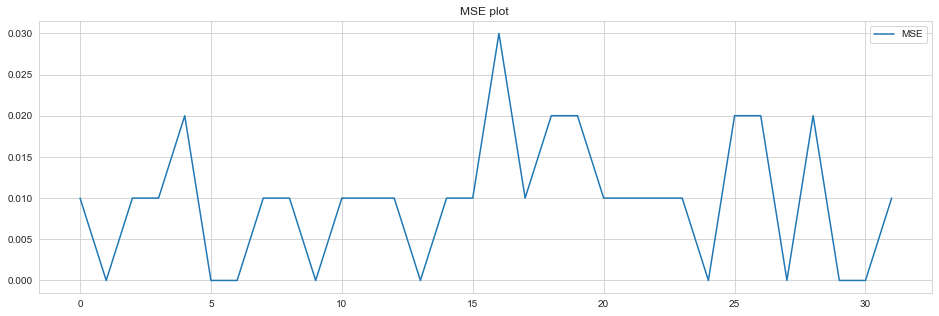


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 13
mean=0.005,median=0.0 ,max=0.02,min=0.0,variance=0.0


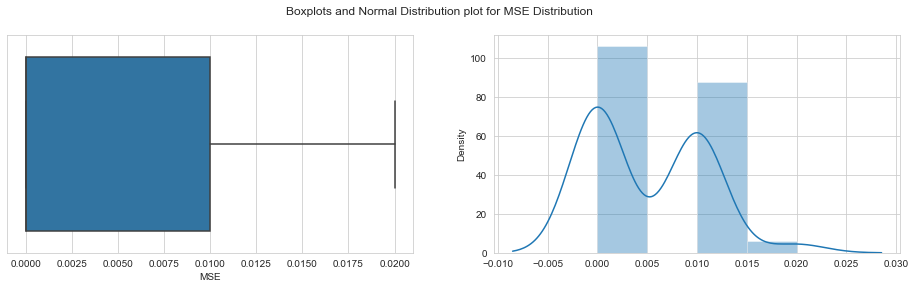

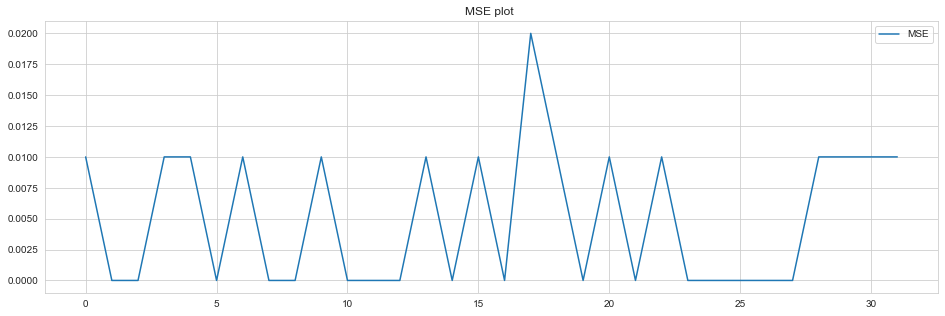


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 14
mean=0.002,median=0.0 ,max=0.04,min=0.0,variance=0.0


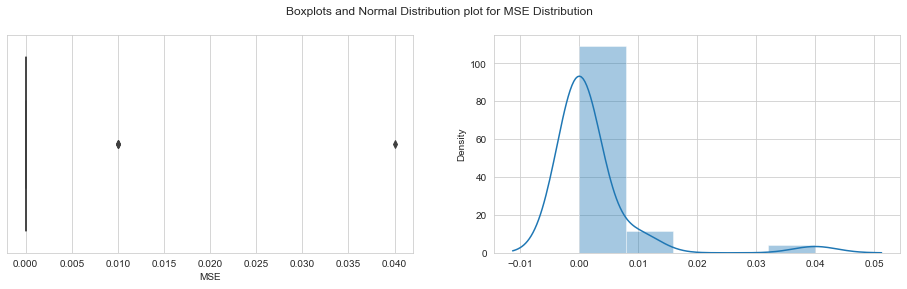

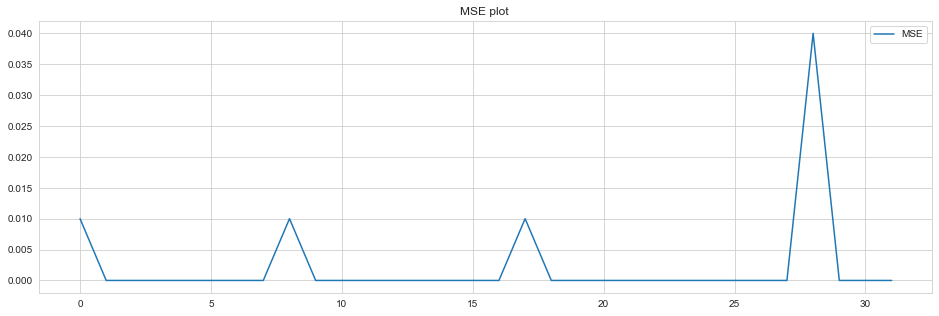


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 15
mean=0.003,median=0.0 ,max=0.01,min=0.0,variance=0.0


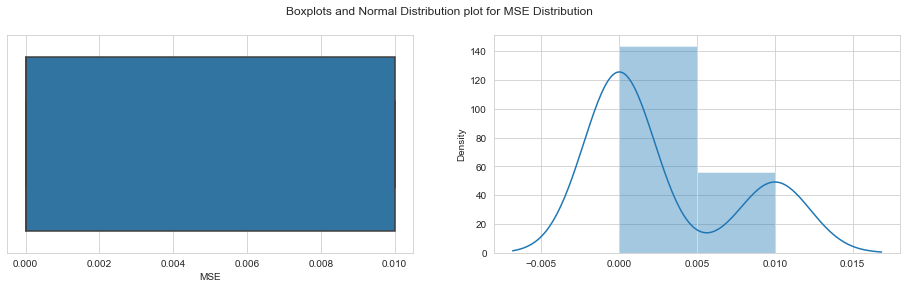

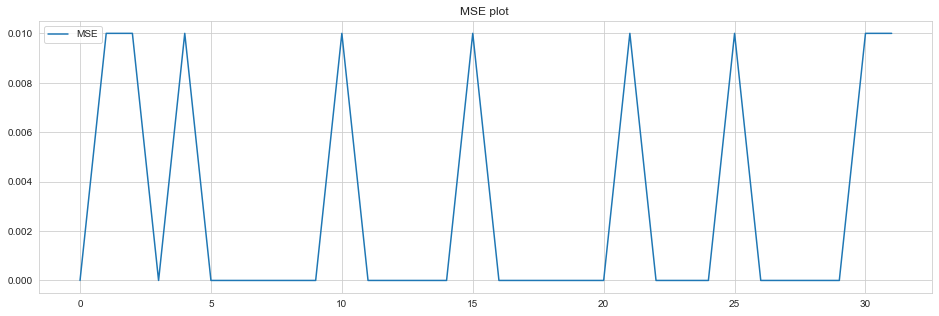


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 16
mean=0.008,median=0.01 ,max=0.02,min=0.0,variance=0.0


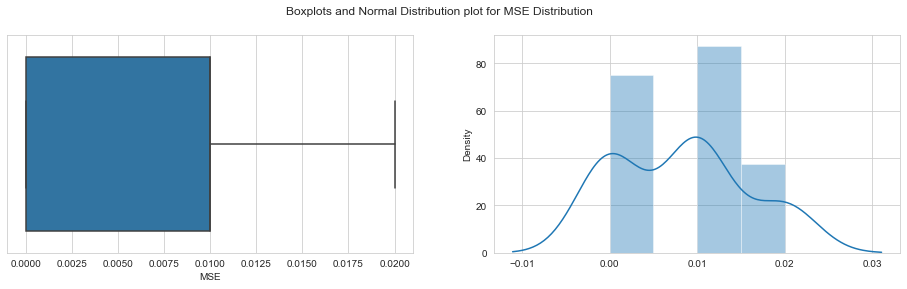

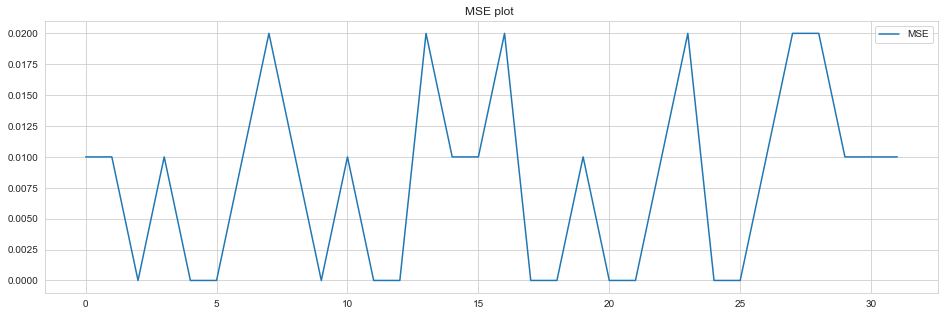


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 17
mean=0.005,median=0.0 ,max=0.03,min=0.0,variance=0.0


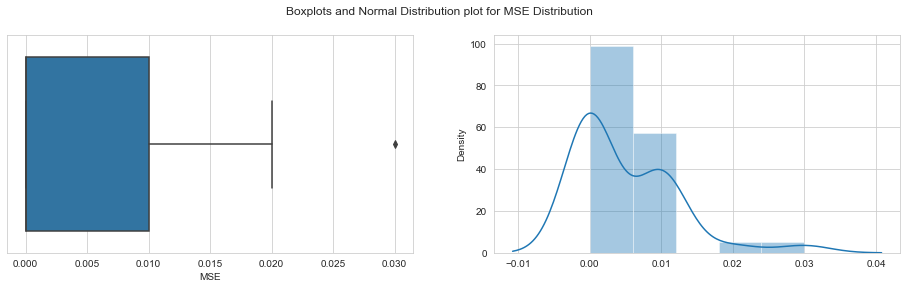

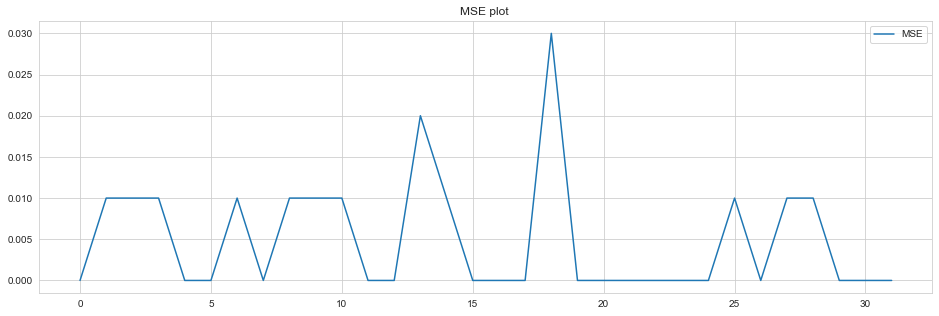


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 18
mean=0.003,median=0.0 ,max=0.01,min=0.0,variance=0.0


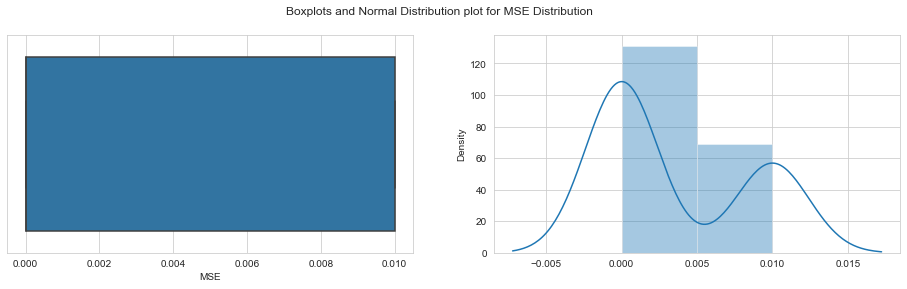

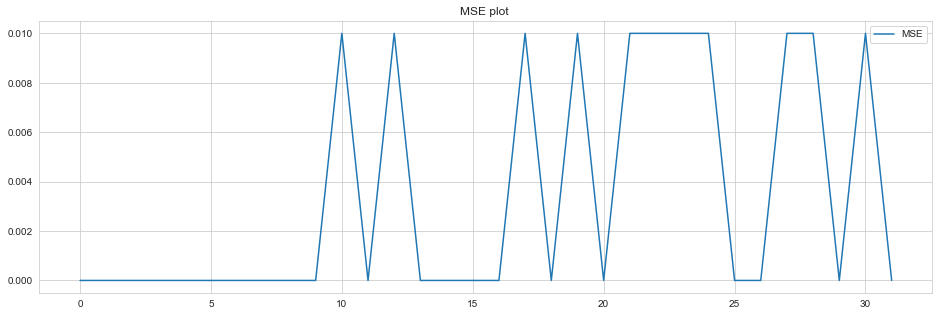


Shapiro_Wilk Test

Anderson_Darling Test

 ********************
Batch: 19
mean=0.009,median=0.01 ,max=0.02,min=0.0,variance=0.0


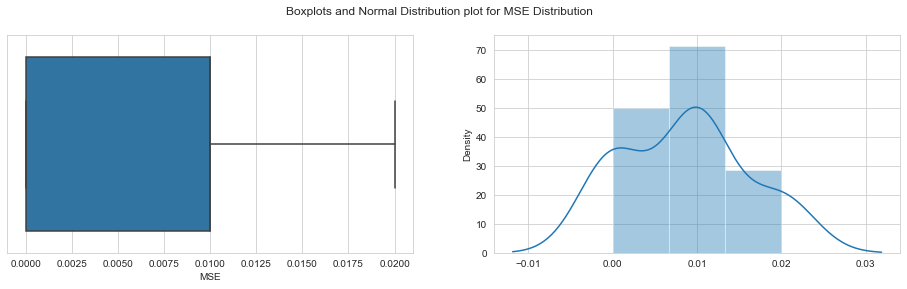

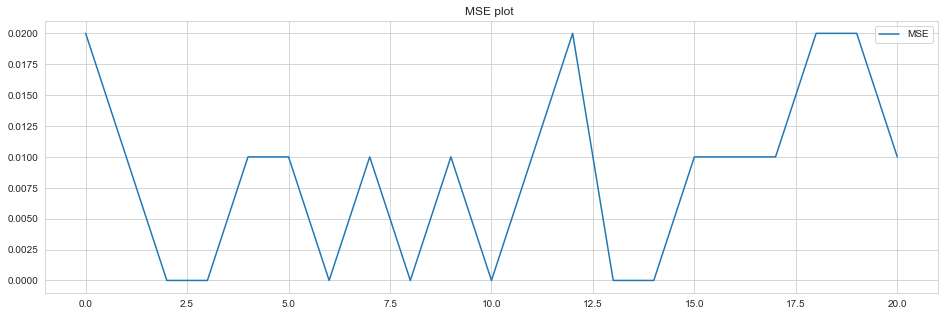


Shapiro_Wilk Test

Anderson_Darling Test


In [649]:
batch_avg_mse_pos,batch_mse_values_pos=check_all_batch_normality(batches_pos,encoder_pos_class,32)

In [654]:
instance_thresh_pos,zscore_list_pos=compute_instance_threshold_firstN_batches(batch_mse_values_pos,2)

In [655]:
instance_thresh_pos

0.0183

In [656]:
thres_iqr_batch_pos, thres_zscore_batch_pos ,thresh_max_batch_pos=compute_batch_threshold_testdata(batch_avg_mse_pos)

In [657]:
thres_zscore_batch_pos

0.0115

In [658]:
# Counts the MSE values exceeding threshold in each batch 
exceed_count_pos,total_pos=threshold_exceed_count(batch_mse_values_pos,instance_thresh_pos)

In [659]:
exceed_list_pos=[]
for key in exceed_count_pos.keys():
    exceed_list_pos.append(exceed_count_pos[key])

mean=0.85,median=0.5 ,max=3,min=0,variance=0.928


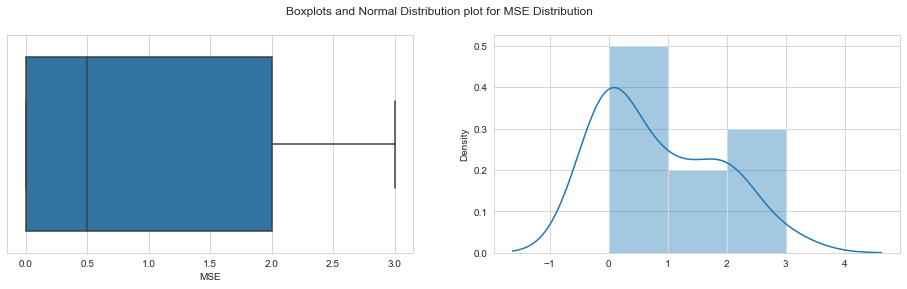

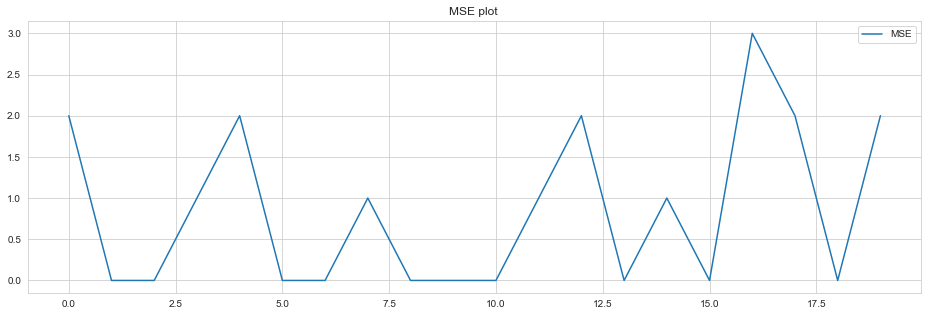

In [660]:
plot_results(exceed_list_pos)

In [661]:
count_thresh_pos=np.max(exceed_list_pos)

In [662]:
count_thresh_pos

3

# Drift Detection

In [663]:
df2=stream.copy()

In [664]:
df2

attribute1  attribute2  attribute3  attribute4  attribute5  attribute6  \
16343       0.352       0.472       0.008       0.137       0.222       0.191   
16344       0.444       0.566       0.006       0.012       0.168       0.130   
16345       0.466       0.572       0.006       0.137       0.158       0.210   
16346       0.462       0.556       0.007       0.226       0.208       0.210   
16347       0.376       0.477       0.008       0.210       0.201       0.170   
...           ...         ...         ...         ...         ...         ...   
18154       0.425       0.461       0.009       0.278       0.441       0.512   
18155       0.465       0.495       0.008       0.278       0.355       0.363   
18156       0.514       0.538       0.007       0.278       0.165       0.170   
18157       0.519       0.536       0.007       0.278       0.115       0.149   
18158       0.464       0.534       0.008       0.270       0.168       0.236   

       attribute7  attribute8  class  
16343       0.338       0.399      1  
16344       0.397       0.504      2  
16345       0.448       0.515      2  
16346       0.440       0.523      1  
16347       0.347       0.429      1  
...           ...         ...    ...  
18154       0.423       0.446      2  
18155       0.561       0.412      1  
18156       0.606       0.480      1  
18157       0.515       0.515      1  
18158       0.530       0.446      1  

[1816 rows x 9 columns]

In [665]:
del df2['class']

In [666]:
df2

attribute1  attribute2  attribute3  attribute4  attribute5  attribute6  \
16343       0.352       0.472       0.008       0.137       0.222       0.191   
16344       0.444       0.566       0.006       0.012       0.168       0.130   
16345       0.466       0.572       0.006       0.137       0.158       0.210   
16346       0.462       0.556       0.007       0.226       0.208       0.210   
16347       0.376       0.477       0.008       0.210       0.201       0.170   
...           ...         ...         ...         ...         ...         ...   
18154       0.425       0.461       0.009       0.278       0.441       0.512   
18155       0.465       0.495       0.008       0.278       0.355       0.363   
18156       0.514       0.538       0.007       0.278       0.165       0.170   
18157       0.519       0.536       0.007       0.278       0.115       0.149   
18158       0.464       0.534       0.008       0.270       0.168       0.236   

       attribute7  attribute8  
16343       0.338       0.399  
16344       0.397       0.504  
16345       0.448       0.515  
16346       0.440       0.523  
16347       0.347       0.429  
...           ...         ...  
18154       0.423       0.446  
18155       0.561       0.412  
18156       0.606       0.480  
18157       0.515       0.515  
18158       0.530       0.446  

[1816 rows x 8 columns]

In [667]:
def make_batches(test_data):
    data=np.array(test_data)
    batch_size=32
    batches={}
    count=0
    for index in range(0,data.shape[0],batch_size):
        batches[count]=data[index:min(index+batch_size,data.shape[0]),:]
        count+=1
    return batches,batch_size
    #print(batch.shape)

In [668]:
batches_n,batch_size=make_batches(df2)

In [669]:
type(batches_n)

dict

In [670]:
def detect_at_batch_level(test_batch,b,batch_thres_pos,batch_thres_neg,count_thresh_pos,count_thres_neg,instance_thresh_pos,instance_thresh_neg, all_excede_list):
    
    # Layer 1 Variables 
    mse_list_layer1=[]     # Holds the MSE values predicted by Layer 1 Autoencoder for a single batch
    exceed_count_layer1=0  # How many instances exceed layer one instance level threshold
    mse_sum=0              # sum of MSE values from layer 1 AE for this batch
    #batch_mse_layer1=[]
    
    
    # Layer 2 Variables 
    mse_list_layer2=[]      # Holds the MSE values predicted by Layer 2 Autoencoder for a single batch
    exceed_count_layer2=-1  # If a batch is not passed to the layer2 AE , then exceed count value will be -1 . This is symbolic.
    mse_sum_layer2=0        # sum of MSE values from layer 2 AE for this batch
    
        
    layer1_excede_list=[] # Hold the batch numbers of bathces exceeding layer thresholds
    #all_excede_list=[]    # Hold the batch number of batches exceeding both Layer-1 and Layer-2 AE Thresholds 
    layer_one_instance_exceed_list=[] # Holds the indices of instances exceeding layer 1 instance threshold
    layer_two_instance_exceed_list=[] # Holds the indices of instances exceeding layer 2 instance thresholds
     
      
    # Determine Layer 1 and Layer AE and their associated thresholds
    layer_one_batch_thres= batch_thres_pos if batch_thres_pos<batch_thres_neg  else batch_thres_neg
    layer_two_batch_thres= batch_thres_pos if batch_thres_pos>batch_thres_neg  else batch_thres_neg
    layer_one_encoder= encoder_pos_class if batch_thres_pos<batch_thres_neg else encoder_neg_class
    layer_two_encoder= encoder_pos_class if batch_thres_pos>batch_thres_neg else encoder_neg_class
    
    layer_one_count_threshold=count_thresh_pos if batch_thres_pos<batch_thres_neg  else count_thres_neg
    layer_two_count_threshold=count_thresh_pos if batch_thres_pos>batch_thres_neg  else count_thres_neg
    
    layer1_ins_thresh=instance_thresh_pos if  batch_thres_pos<batch_thres_neg  else instance_thresh_neg
    layer2_ins_thresh=instance_thresh_pos if  batch_thres_pos>batch_thres_neg  else instance_thresh_neg
    
    # Pass each instance of a batch from Layer 1 AE. Compute Batch MSE and Number of Instances excceding Layer 1 Instance Thresh       
    avg_mse_layer1=0
    for i in range(0,test_batch.shape[0]):
        ROW = np.array([test_batch[i]])
        pred= layer_one_encoder.predict(ROW) 
        mse = np.round(np.mean(np.power(test_batch[i] - pred, 2)),5)
        mse_list_layer1.append(mse)
        if mse>layer1_ins_thresh:
            exceed_count_layer1+=1
            layer_one_instance_exceed_list.append(i)
        mse_sum+=mse    
    avg_mse_layer1=(mse_sum)/len(test_batch)
    avg_mse_layer2=0 
    # Check if This batch exceeds both Layer 1 batch and count thresholds
    if ((avg_mse_layer1>layer_one_batch_thres) and ( exceed_count_layer1 >layer_one_count_threshold) ):
        layer1_excede_list.append(b)# Keep track of batches exceesding layer 1 thresholds
        exceed_count_layer2=0
        # Pass each instance of this batch to Layer 2 AE. Compute Batch MSE and Number of Instances excceding Layer 2 Instance Thresh
        for i in range(0,test_batch.shape[0]):
            ROW = np.array([test_batch[i]])
            pred= layer_two_encoder.predict(ROW) 
            mse = np.round(np.mean(np.power(test_batch[i] - pred, 2)),5)
            mse_list_layer2.append(mse)
            if mse>layer2_ins_thresh:
                exceed_count_layer2+=1
                layer_two_instance_exceed_list.append(i)
            mse_sum_layer2+=mse    
        avg_mse_layer2=(mse_sum_layer2)/len(test_batch)
        
        if  (avg_mse_layer2 > layer_two_batch_thres) and (exceed_count_layer2>layer_two_count_threshold):
            all_excede_list.append(b)# Keep track of batches exceesding layer 2 thresholds
          
    return  all_excede_list,mse_list_layer1 , exceed_count_layer1 ,avg_mse_layer2,exceed_count_layer2,len(layer_two_instance_exceed_list),layer_two_batch_thres,layer_two_count_threshold,layer_one_instance_exceed_list,layer_two_instance_exceed_list,avg_mse_layer1 

In [671]:
# This function makes a list of dictionary values
def return_list_of_dict_values(d):
    values_list=[]
    for key in d.keys():
        values_list.append(d[key])
    return values_list

In [704]:
# This function takes two lists of Batch MSE and Exceed Counts along with Batch and Count Thresholds of Layer 2 AE
# If three consecutive bathces exceed booth thresholds , warning is generated and for 10 consectutive batches drift is confirmed.
def detect_drift(batch_mse,exceed_list, Thresh,count_thresh):
    n=0 # total number of batches where MSE exceeds threshold
    count=0 ## counts the number of consecutive batches exceding threshold
    w_count=0 # Count of elements in Window. Windows contains batch number where batch MSE exceeds
              #threshold 
    w_index_list=[] # Contains indices of batches where batch MSE esceeds threshold 
    for i in range(0,len(batch_mse)):
        #print (batch_mse)
        if(((batch_mse[i])>Thresh) and (exceed_list[i]>count_thresh)):
            print(' Threshold exceeds at batch : {}'.format(i))
            n=n+1
            print('Cumulative Batch Count Exceeding Threshold : {}'.format(n))
            if(len(w_index_list)==0 or (i-w_index_list[-1]==1)):
                # Check if w_index_list is empty or its last entry is the previous batch
                    w_index_list.append(i)# then append this batch to w_index_list
            count+=1
            #if (i!= w_index_list[-1]
            #print ("Batch %d MSE exceeds Threshold" %i)
            print(w_index_list)
            if (count>5):# if for more than nine consecutive batches , batch MSE esceeds threshold , then 
                         # confirm drift
                drift_batch=i-9 # at the first batch i this window

                print( " Drift Confirmed at Batch No : % d" %drift_batch)
        
        
        if(batch_mse[i])<Thresh:
            count=0 # reset count 
            if len(w_index_list)>=3:
                w_level=i-len(w_index_list)
                print("Warning Level at Batch",w_level)
            if len(w_index_list)<=10:
                w_index_list=[]
        
   

In [673]:
def detect_stream_drift(batches,encoder_pos_class,encoder_neg_class,batch_thres_pos,batch_thres_neg, count_thresh_pos,count_thres_neg):
    exceed_count_layer2_instance_thresh={} # Holds Number of instances exceeding thresholds of Both Layer 1 and layer 2 AE.
    
    mse_dict_L1={}         # Holds batchwise MSE values from Layer 1 AE
    exceed_count_L1={}     # Batchwise number of Instances exceeding layer 1 count threshold
    layer_one_instance_exceed_list={} # batch wise list of instances ( indices ) exceeding Layer 1 count threshold
    avg_mse_l1={}
    
    mse_dict_L2={}        # Holds batchwise MSE values from Layer 2 AE
    exceed_count_L2={}    # Batchwise number of Instances exceeding layer 2 count threshold
    layer_two_instance_exceed_list={} # For each batch maintains the indices where MSE exceeds layer 2 threshold
    avg_mse_l2={}         #
    all_excede_list=[]
    n=0
    for b in batches:
        print("\n\n")
        print("**************")
        print('\nBatch Number : {}'.format(b))
        all_excede_list,mse_dict_L1[b],exceed_count_L1[b],avg_mse_l2[b],exceed_count_L2[b],exceed_count_layer2_instance_thresh[b],layer_two_batch_thres,layer_two_count_threshold,layer_one_instance_exceed_list[b],layer_two_instance_exceed_list[b],avg_mse_l1[b]= detect_at_batch_level(batches[b],b,batch_thres_pos,batch_thres_neg,count_thresh_pos,count_thres_neg,instance_thresh_pos,instance_thresh_neg, all_excede_list)
             
        
        print('\nData Points Exceeding Layer 1 Encoder Instance Threshold : {} '.format(layer_one_instance_exceed_list[b]))
        print('\nData Points Exceeding Layer 2 Encoder Instance Threshold: {}'.format(layer_two_instance_exceed_list[b])) 
        print('\nNumber of Data Points Exceeding Layer 2 Encoder Instance thresholds: {}'.format(exceed_count_layer2_instance_thresh[b]))
        
    mse_list_layer1=return_list_of_dict_values(avg_mse_l1)
    exceed_count_list_layer1=return_list_of_dict_values(exceed_count_L1)
    
    
    ## Detect Drift at Batch Level 
    print ("\n Drift Detection at Batch Level\n")
    exceed_list=return_list_of_dict_values(exceed_count_L2)
    mse_list=return_list_of_dict_values(avg_mse_l2)
    detect_drift(mse_list,exceed_list,layer_two_batch_thres,layer_two_count_threshold )
        
    return all_excede_list,exceed_count_layer2_instance_thresh ,exceed_count_L2,avg_mse_l2 ,mse_list_layer1,exceed_count_list_layer1




In [674]:
type(batches_n)

dict

In [675]:
all_excede_list_n,exceed_count_L2_instThresh_n ,exceed_count_L2_countThresh_n,avg_mse_l2_list_n,mse_list_layer1_n,exceed_count_list_layer1_n=detect_stream_drift(batches_n,encoder_pos_class,encoder_neg_class,thres_zscore_batch_pos,thres_zscore_batch_neg, count_thresh_pos,count_thresh_neg)




**************

Batch Number : 0

Data Points Exceeding Layer 1 Encoder Instance Threshold : [1, 8, 30] 

Data Points Exceeding Layer 2 Encoder Instance Threshold: []

Number of Data Points Exceeding Layer 2 Encoder Instance thresholds: 0



**************

Batch Number : 1

Data Points Exceeding Layer 1 Encoder Instance Threshold : [1, 19, 20, 25] 

Data Points Exceeding Layer 2 Encoder Instance Threshold: []

Number of Data Points Exceeding Layer 2 Encoder Instance thresholds: 0



**************

Batch Number : 2

Data Points Exceeding Layer 1 Encoder Instance Threshold : [16] 

Data Points Exceeding Layer 2 Encoder Instance Threshold: []

Number of Data Points Exceeding Layer 2 Encoder Instance thresholds: 0



**************

Batch Number : 3

Data Points Exceeding Layer 1 Encoder Instance Threshold : [2] 

Data Points Exceeding Layer 2 Encoder Instance Threshold: []

Number of Data Points Exceeding Layer 2 Encoder Instance thresholds: 0



**************

Batch Number : 4

Dat

mean=0.008,median=0.01 ,max=0.02,min=0.0,variance=0.0


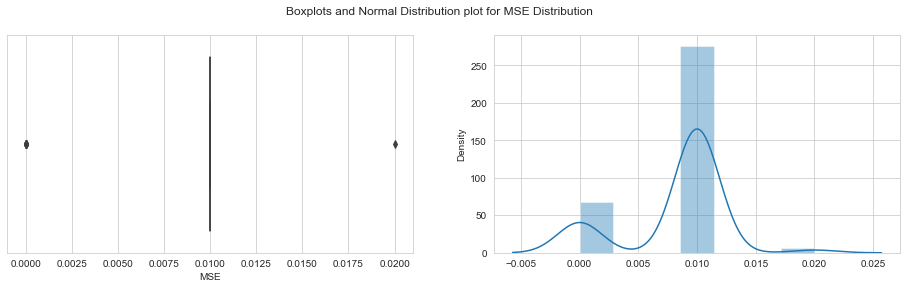

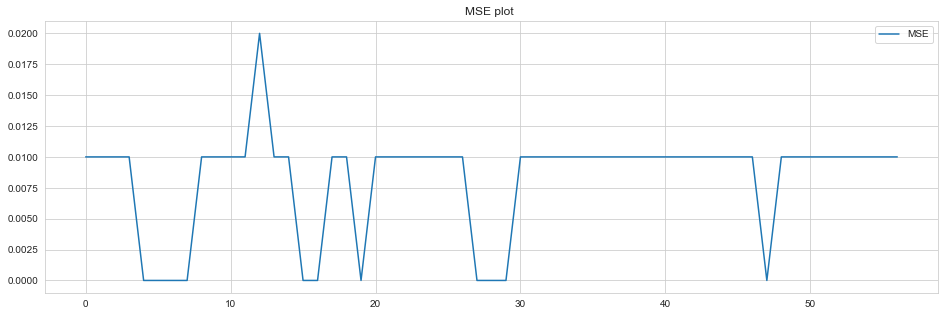

In [676]:
plot_results(mse_list_layer1_n)

In [677]:
avg_mse_l2_list_n;

In [678]:
# This function makes a list of dictionary values
def return_list_of_dict_values(d):
    values_list=[]
    for key in d.keys():
        values_list.append(d[key])
    return values_list

In [679]:
avg_mse_l2_list_n=return_list_of_dict_values(avg_mse_l2_list_n)

mean=0.001,median=0.0 ,max=0.01,min=0.0,variance=0.0


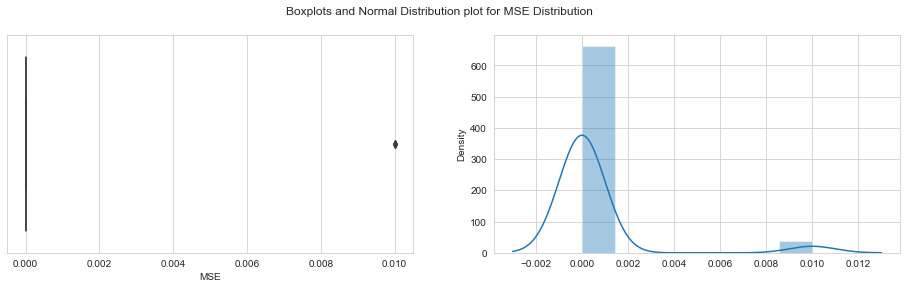

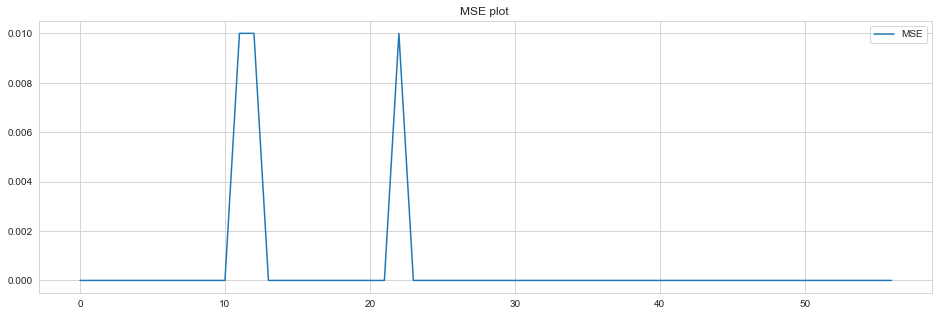

In [680]:
plot_results(avg_mse_l2_list_n)

## Adding Drift to Stream Data 

In [681]:
def make_drifted_data(normal_data, nfeatures, shift):
    drifted_data=normal_data.copy()
    for i in range (1,nfeatures+1):
        drifted_data[drifted_data.columns[i-1]]+=shift
        #print(normal_data[normal_data.columns[i]])
    return drifted_data

In [682]:
stream

attribute1  attribute2  attribute3  attribute4  attribute5  attribute6  \
16343       0.352       0.472       0.008       0.137       0.222       0.191   
16344       0.444       0.566       0.006       0.012       0.168       0.130   
16345       0.466       0.572       0.006       0.137       0.158       0.210   
16346       0.462       0.556       0.007       0.226       0.208       0.210   
16347       0.376       0.477       0.008       0.210       0.201       0.170   
...           ...         ...         ...         ...         ...         ...   
18154       0.425       0.461       0.009       0.278       0.441       0.512   
18155       0.465       0.495       0.008       0.278       0.355       0.363   
18156       0.514       0.538       0.007       0.278       0.165       0.170   
18157       0.519       0.536       0.007       0.278       0.115       0.149   
18158       0.464       0.534       0.008       0.270       0.168       0.236   

       attribute7  attribute8  class  
16343       0.338       0.399      1  
16344       0.397       0.504      2  
16345       0.448       0.515      2  
16346       0.440       0.523      1  
16347       0.347       0.429      1  
...           ...         ...    ...  
18154       0.423       0.446      2  
18155       0.561       0.412      1  
18156       0.606       0.480      1  
18157       0.515       0.515      1  
18158       0.530       0.446      1  

[1816 rows x 9 columns]

<AxesSubplot:xlabel='class', ylabel='attribute2'>

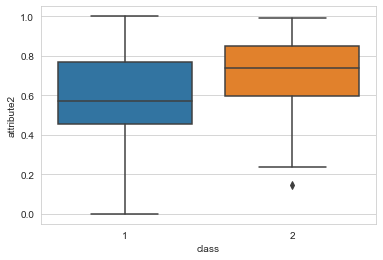

In [683]:
 sns.boxplot( x = 'class',y = 'attribute2', data = df )

In [684]:
df_data=make_drifted_data(stream, 1, -0.3)

In [685]:
df_data

attribute1  attribute2  attribute3  attribute4  attribute5  attribute6  \
16343       0.052       0.472       0.008       0.137       0.222       0.191   
16344       0.144       0.566       0.006       0.012       0.168       0.130   
16345       0.166       0.572       0.006       0.137       0.158       0.210   
16346       0.162       0.556       0.007       0.226       0.208       0.210   
16347       0.076       0.477       0.008       0.210       0.201       0.170   
...           ...         ...         ...         ...         ...         ...   
18154       0.125       0.461       0.009       0.278       0.441       0.512   
18155       0.165       0.495       0.008       0.278       0.355       0.363   
18156       0.214       0.538       0.007       0.278       0.165       0.170   
18157       0.219       0.536       0.007       0.278       0.115       0.149   
18158       0.164       0.534       0.008       0.270       0.168       0.236   

       attribute7  attribute8  class  
16343       0.338       0.399      1  
16344       0.397       0.504      2  
16345       0.448       0.515      2  
16346       0.440       0.523      1  
16347       0.347       0.429      1  
...           ...         ...    ...  
18154       0.423       0.446      2  
18155       0.561       0.412      1  
18156       0.606       0.480      1  
18157       0.515       0.515      1  
18158       0.530       0.446      1  

[1816 rows x 9 columns]

In [686]:
del df_data['class']

In [687]:
batches_d,batch_size=make_batches(df_data)

In [705]:
all_excede_list_d,exceed_count_L2_instThresh_d ,exceed_count_L2_countThresh_d,avg_mse_l2_list_d,mse_list_layer1_d,exceed_count_list_layer1_d=detect_stream_drift(batches_d,encoder_pos_class,encoder_neg_class,thres_zscore_batch_pos,thres_zscore_batch_neg, count_thresh_pos,count_thresh_neg)




**************

Batch Number : 0

Data Points Exceeding Layer 1 Encoder Instance Threshold : [0, 1, 2, 8, 9, 12, 14, 15, 16, 20, 21, 22, 26, 28, 29, 30, 31] 

Data Points Exceeding Layer 2 Encoder Instance Threshold: [0, 1, 2, 3, 4, 5, 8, 17, 18, 24, 28]

Number of Data Points Exceeding Layer 2 Encoder Instance thresholds: 11



**************

Batch Number : 1

Data Points Exceeding Layer 1 Encoder Instance Threshold : [0, 1, 2, 5, 6, 7, 10, 11, 14, 18, 19, 20, 24, 25, 26] 

Data Points Exceeding Layer 2 Encoder Instance Threshold: [1, 16, 22, 23, 24, 29, 30, 31]

Number of Data Points Exceeding Layer 2 Encoder Instance thresholds: 8



**************

Batch Number : 2

Data Points Exceeding Layer 1 Encoder Instance Threshold : [0, 1, 6, 16, 17, 18, 20, 24, 29] 

Data Points Exceeding Layer 2 Encoder Instance Threshold: [0, 11, 12, 16, 24, 25, 26, 27, 28]

Number of Data Points Exceeding Layer 2 Encoder Instance thresholds: 9



**************

Batch Number : 3

Data Points Exceedi

In [689]:
avg_mse_l2_list_d=return_list_of_dict_values(avg_mse_l2_list_d)

mean=0.013,median=0.02 ,max=0.02,min=0.0,variance=0.0


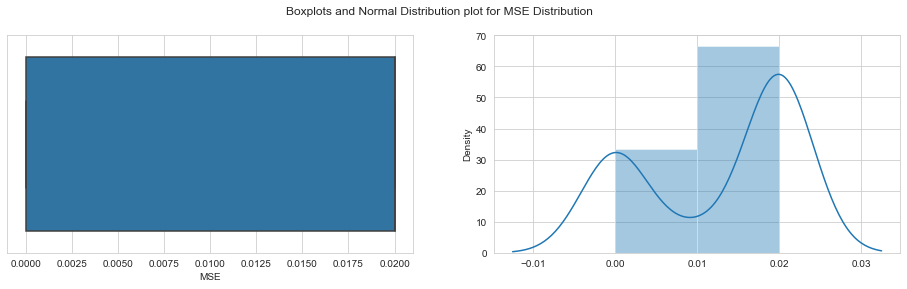

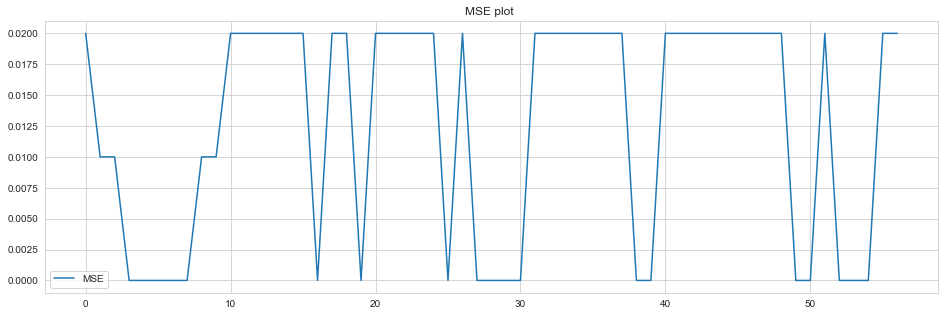

In [690]:
plot_results(avg_mse_l2_list_d)

mean=0.014,median=0.01 ,max=0.03,min=0.01,variance=0.0


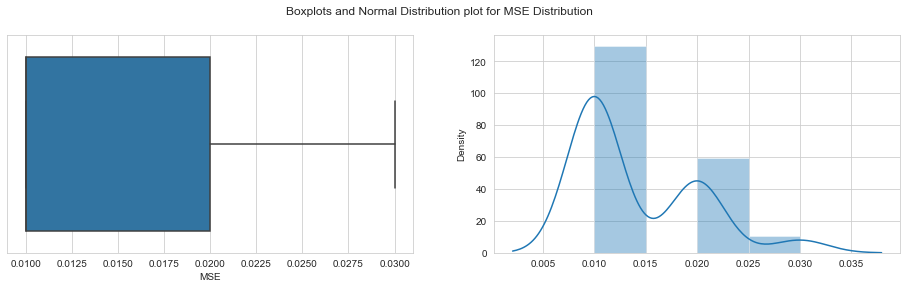

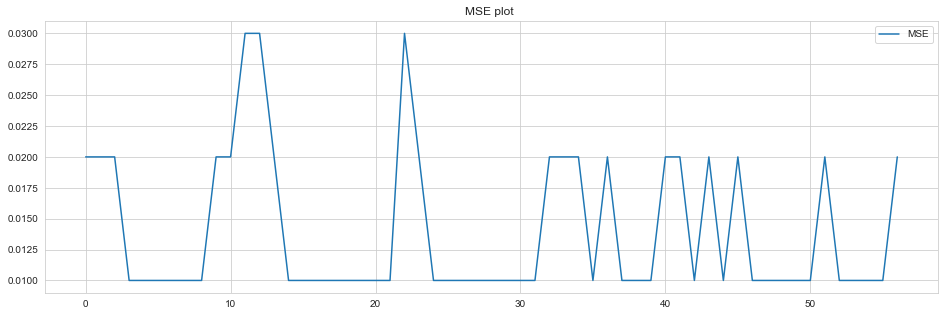

In [691]:
plot_results(mse_list_layer1_d)

In [524]:
df_data=make_drifted_data(stream, 1, -0.3)

<AxesSubplot:xlabel='class', ylabel='attribute1'>

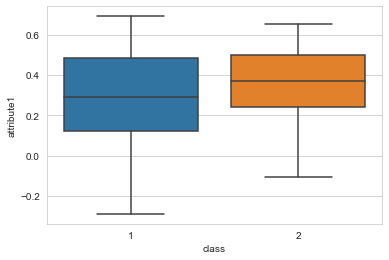

In [525]:
 sns.boxplot( x = 'class',y = 'attribute1', data = df_data )

<AxesSubplot:xlabel='class', ylabel='attribute1'>

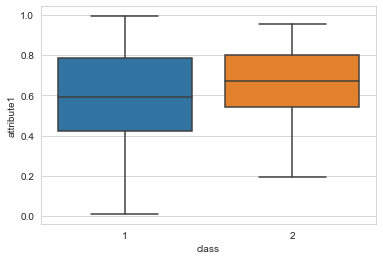

In [526]:
 sns.boxplot( x = 'class',y = 'attribute1', data = stream )

# t-Test 

In [692]:
def two_sample_tTest(sample1, sample2,alpha) :
    t_value,p_value=stats.ttest_ind(sample1,sample2)
    print('Test statistic is %f'%float("{:.6f}".format(t_value)))
    print('p-value for two tailed test is %f'%p_value)
    if p_value<=alpha:
        print('Conclusion :\n''Since p-value(=%f)'%p_value,'<','alpha(=%.2f)'%alpha,'''We reject the null hypothesis H0 and Accept H1 . So we conclude that\nThere is a drift in the dataset at %.2f level of significance.'''%alpha)
    else:
        print( 'Accept H0: There is no drift in the dataset')

In [693]:
two_sample_tTest(mse_list_layer1_d,mse_list_layer1_n, alpha=0.05)

Test statistic is 12.726082
p-value for two tailed test is 0.000000
Conclusion :
Since p-value(=0.000000) < alpha(=0.05) We reject the null hypothesis H0 and Accept H1 . So we conclude that
There is a drift in the dataset at 0.05 level of significance.


In [694]:
two_sample_tTest(exceed_count_list_layer1_n,exceed_count_list_layer1_d, alpha=0.05)

Test statistic is -6.365952
p-value for two tailed test is 0.000000
Conclusion :
Since p-value(=0.000000) < alpha(=0.05) We reject the null hypothesis H0 and Accept H1 . So we conclude that
There is a drift in the dataset at 0.05 level of significance.


In [696]:
two_sample_tTest(avg_mse_l2_list_d,avg_mse_l2_list_n, alpha=0.05)

Test statistic is 9.356238
p-value for two tailed test is 0.000000
Conclusion :
Since p-value(=0.000000) < alpha(=0.05) We reject the null hypothesis H0 and Accept H1 . So we conclude that
There is a drift in the dataset at 0.05 level of significance.


In [699]:
exceed_count_L2_instThresh_d_values=return_list_of_dict_values(exceed_count_L2_instThresh_d)

In [700]:
exceed_count_L2_instThresh_n_values=return_list_of_dict_values(exceed_count_L2_instThresh_n)

In [703]:
two_sample_tTest(exceed_count_L2_instThresh_d_values,exceed_count_L2_instThresh_n_values, alpha=0.05)

Test statistic is 8.134354
p-value for two tailed test is 0.000000
Conclusion :
Since p-value(=0.000000) < alpha(=0.05) We reject the null hypothesis H0 and Accept H1 . So we conclude that
There is a drift in the dataset at 0.05 level of significance.


# Classification 

In [527]:
stream['class'].value_counts()

1    1165
2     651
Name: class, dtype: int64

In [528]:
data , train, test, X_positive,X_negative , stream

(       attribute1  attribute2  attribute3  attribute4  attribute5  attribute6  \
 0           0.302       0.384       0.009       0.335       0.351       0.297   
 1           0.369       0.464       0.006       0.323       0.387       0.363   
 2           0.444       0.567       0.005       0.153       0.491       0.427   
 3           0.366       0.457       0.006       0.319       0.667       0.599   
 4           0.253       0.325       0.007       0.323       0.502       0.427   
 ...           ...         ...         ...         ...         ...         ...   
 18154       0.425       0.461       0.009       0.278       0.441       0.512   
 18155       0.465       0.495       0.008       0.278       0.355       0.363   
 18156       0.514       0.538       0.007       0.278       0.165       0.170   
 18157       0.519       0.536       0.007       0.278       0.115       0.149   
 18158       0.464       0.534       0.008       0.270       0.168       0.236   
 
        attrib

In [529]:
y_train=train['class'].values

In [530]:
len(y_train)

14527

In [531]:
del train['class']

In [532]:
X_train=train.values

In [533]:
len(X_train)

14527

In [534]:
y_test=test['class'].values
del test['class']
X_test=test.values

# Gaussian NB

In [535]:
from sklearn.naive_bayes import GaussianNB
clf1 = GaussianNB().fit(X_train, y_train) 

In [542]:
def classification_report(model,X_test,y_test):
    prediction_test = model.predict(X_test)
    # Print the prediction accuracy
    accuracy = metrics.accuracy_score(y_test, prediction_test)
    confusion_matrix = metrics.confusion_matrix(y_test, prediction_test)
    classification = metrics.classification_report(y_test, prediction_test)

    print('============================== Model Evaluation ==============================')
    print('Classifier :',model)
    print("\n Model Accuracy:" "\n", accuracy)
    print()
    print("Confusion matrix:" "\n", confusion_matrix)
    print()
    print("Classification report:" "\n", classification) 

In [537]:
classification_report(clf1,X_test,y_test)

============================== Model Evaluation ==============================
Classifier : GaussianNB()

 Model Accuracy:
 0.7015418502202643

Confusion matrix:
 [[944 243]
 [299 330]]

Classification report:
               precision    recall  f1-score   support

           1       0.76      0.80      0.78      1187
           2       0.58      0.52      0.55       629

    accuracy                           0.70      1816
   macro avg       0.67      0.66      0.66      1816
weighted avg       0.70      0.70      0.70      1816



In [538]:
class_names=[1,0]
def plot_conf_matrix(y_test, prediction_test, class_names):
    cnf_matrix = metrics.confusion_matrix(y_test, prediction_test)
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    

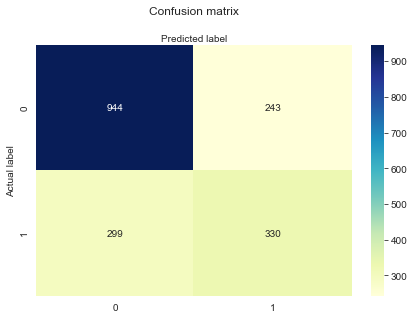

In [539]:
prediction_test=clf1.predict(X_test)
plot_conf_matrix(y_test,prediction_test,class_names)

# Logistic Regression

In [540]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import roc_auc_score,roc_curve
clf2 = LogisticRegression().fit(X_train,y_train)

In [543]:
classification_report(clf2,X_test,y_test)

============================== Model Evaluation ==============================
Classifier : LogisticRegression()

 Model Accuracy:
 0.7698237885462555

Confusion matrix:
 [[1086  101]
 [ 317  312]]

Classification report:
               precision    recall  f1-score   support

           1       0.77      0.91      0.84      1187
           2       0.76      0.50      0.60       629

    accuracy                           0.77      1816
   macro avg       0.76      0.71      0.72      1816
weighted avg       0.77      0.77      0.76      1816



# DT

In [544]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
clf3=DecisionTreeClassifier(criterion="entropy", max_depth=6)
clf3.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=6)

In [545]:
classification_report(clf3,X_test,y_test) 

============================== Model Evaluation ==============================
Classifier : DecisionTreeClassifier(criterion='entropy', max_depth=6)

 Model Accuracy:
 0.7687224669603524

Confusion matrix:
 [[1100   87]
 [ 333  296]]

Classification report:
               precision    recall  f1-score   support

           1       0.77      0.93      0.84      1187
           2       0.77      0.47      0.58       629

    accuracy                           0.77      1816
   macro avg       0.77      0.70      0.71      1816
weighted avg       0.77      0.77      0.75      1816



# KNN

In [546]:
from sklearn.neighbors import KNeighborsClassifier
clf4 = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train) 

In [547]:
classification_report(clf4,X_test,y_test) 

============================== Model Evaluation ==============================
Classifier : KNeighborsClassifier()

 Model Accuracy:
 0.7720264317180616

Confusion matrix:
 [[1062  125]
 [ 289  340]]

Classification report:
               precision    recall  f1-score   support

           1       0.79      0.89      0.84      1187
           2       0.73      0.54      0.62       629

    accuracy                           0.77      1816
   macro avg       0.76      0.72      0.73      1816
weighted avg       0.77      0.77      0.76      1816



# SVM

In [548]:
from sklearn.svm import SVC
clf5 = SVC(kernel='linear', probability=True).fit(X_train, y_train) 
classification_report(clf5,X_test,y_test) 

============================== Model Evaluation ==============================
Classifier : SVC(kernel='linear', probability=True)

 Model Accuracy:
 0.7852422907488987

Confusion matrix:
 [[1084  103]
 [ 287  342]]

Classification report:
               precision    recall  f1-score   support

           1       0.79      0.91      0.85      1187
           2       0.77      0.54      0.64       629

    accuracy                           0.79      1816
   macro avg       0.78      0.73      0.74      1816
weighted avg       0.78      0.79      0.77      1816



# Random Forest

In [549]:
from sklearn.ensemble import RandomForestClassifier
clf6 = RandomForestClassifier(n_estimators=100)
clf6.fit(X_train, y_train)
classification_report(clf6,X_test,y_test) 

============================== Model Evaluation ==============================
Classifier : RandomForestClassifier()

 Model Accuracy:
 0.8001101321585903

Confusion matrix:
 [[1105   82]
 [ 281  348]]

Classification report:
               precision    recall  f1-score   support

           1       0.80      0.93      0.86      1187
           2       0.81      0.55      0.66       629

    accuracy                           0.80      1816
   macro avg       0.80      0.74      0.76      1816
weighted avg       0.80      0.80      0.79      1816



# XGBOOST 

In [550]:
from sklearn.ensemble import GradientBoostingClassifier
clf7 = GradientBoostingClassifier().fit(X_train, y_train)
classification_report(clf7,X_test,y_test) 

============================== Model Evaluation ==============================
Classifier : GradientBoostingClassifier()

 Model Accuracy:
 0.7979074889867841

Confusion matrix:
 [[1113   74]
 [ 293  336]]

Classification report:
               precision    recall  f1-score   support

           1       0.79      0.94      0.86      1187
           2       0.82      0.53      0.65       629

    accuracy                           0.80      1816
   macro avg       0.81      0.74      0.75      1816
weighted avg       0.80      0.80      0.79      1816



In [551]:
from sklearn.neural_network import MLPClassifier
clf8 = MLPClassifier(hidden_layer_sizes=(100,), max_iter=100, alpha=1e-4,
                    solver='sgd', verbose=True, tol=1e-5, random_state=1,
                    learning_rate_init=0.001)

clf8.fit(X_train, y_train)
classification_report(clf8,X_test,y_test)

Iteration 1, loss = 0.64280936
Iteration 2, loss = 0.62193529
Iteration 3, loss = 0.61468527
Iteration 4, loss = 0.61023634
Iteration 5, loss = 0.60656759
Iteration 6, loss = 0.60329328
Iteration 7, loss = 0.60015925
Iteration 8, loss = 0.59722388
Iteration 9, loss = 0.59441081
Iteration 10, loss = 0.59157992
Iteration 11, loss = 0.58866439
Iteration 12, loss = 0.58578236
Iteration 13, loss = 0.58300168
Iteration 14, loss = 0.58037628
Iteration 15, loss = 0.57790434
Iteration 16, loss = 0.57551401
Iteration 17, loss = 0.57320051
Iteration 18, loss = 0.57096854
Iteration 19, loss = 0.56881302
Iteration 20, loss = 0.56668431
Iteration 21, loss = 0.56462081
Iteration 22, loss = 0.56257579
Iteration 23, loss = 0.56055507
Iteration 24, loss = 0.55857509
Iteration 25, loss = 0.55663056
Iteration 26, loss = 0.55475217
Iteration 27, loss = 0.55291871
Iteration 28, loss = 0.55115665
Iteration 29, loss = 0.54941316
Iteration 30, loss = 0.54774071
Iteration 31, loss = 0.54607987
Iteration 32, los

# Performance on Test Data 

In [552]:
stream

attribute1  attribute2  attribute3  attribute4  attribute5  attribute6  \
16343       0.352       0.472       0.008       0.137       0.222       0.191   
16344       0.444       0.566       0.006       0.012       0.168       0.130   
16345       0.466       0.572       0.006       0.137       0.158       0.210   
16346       0.462       0.556       0.007       0.226       0.208       0.210   
16347       0.376       0.477       0.008       0.210       0.201       0.170   
...           ...         ...         ...         ...         ...         ...   
18154       0.425       0.461       0.009       0.278       0.441       0.512   
18155       0.465       0.495       0.008       0.278       0.355       0.363   
18156       0.514       0.538       0.007       0.278       0.165       0.170   
18157       0.519       0.536       0.007       0.278       0.115       0.149   
18158       0.464       0.534       0.008       0.270       0.168       0.236   

       attribute7  attribute8  class  
16343       0.338       0.399      1  
16344       0.397       0.504      2  
16345       0.448       0.515      2  
16346       0.440       0.523      1  
16347       0.347       0.429      1  
...           ...         ...    ...  
18154       0.423       0.446      2  
18155       0.561       0.412      1  
18156       0.606       0.480      1  
18157       0.515       0.515      1  
18158       0.530       0.446      1  

[1816 rows x 9 columns]

In [553]:
y1_test=stream['class'].values
del stream['class']
X1_test=stream.values

# Niave Bayes

In [554]:
classification_report(clf1,X1_test,y1_test)

============================== Model Evaluation ==============================
Classifier : GaussianNB()

 Model Accuracy:
 0.6216960352422908

Confusion matrix:
 [[657 508]
 [179 472]]

Classification report:
               precision    recall  f1-score   support

           1       0.79      0.56      0.66      1165
           2       0.48      0.73      0.58       651

    accuracy                           0.62      1816
   macro avg       0.63      0.64      0.62      1816
weighted avg       0.68      0.62      0.63      1816



# Logistic Regression 

In [555]:
classification_report(clf2,X1_test,y1_test)

============================== Model Evaluation ==============================
Classifier : LogisticRegression()

 Model Accuracy:
 0.7136563876651982

Confusion matrix:
 [[870 295]
 [225 426]]

Classification report:
               precision    recall  f1-score   support

           1       0.79      0.75      0.77      1165
           2       0.59      0.65      0.62       651

    accuracy                           0.71      1816
   macro avg       0.69      0.70      0.70      1816
weighted avg       0.72      0.71      0.72      1816



# DT

In [556]:
classification_report(clf3,X1_test,y1_test)

============================== Model Evaluation ==============================
Classifier : DecisionTreeClassifier(criterion='entropy', max_depth=6)

 Model Accuracy:
 0.6806167400881057

Confusion matrix:
 [[810 355]
 [225 426]]

Classification report:
               precision    recall  f1-score   support

           1       0.78      0.70      0.74      1165
           2       0.55      0.65      0.59       651

    accuracy                           0.68      1816
   macro avg       0.66      0.67      0.67      1816
weighted avg       0.70      0.68      0.69      1816



# KNN

In [557]:
classification_report(clf4,X1_test,y1_test)

============================== Model Evaluation ==============================
Classifier : KNeighborsClassifier()

 Model Accuracy:
 0.7318281938325991

Confusion matrix:
 [[893 272]
 [215 436]]

Classification report:
               precision    recall  f1-score   support

           1       0.81      0.77      0.79      1165
           2       0.62      0.67      0.64       651

    accuracy                           0.73      1816
   macro avg       0.71      0.72      0.71      1816
weighted avg       0.74      0.73      0.73      1816



# SVM

In [558]:
classification_report(clf5,X1_test,y1_test)

============================== Model Evaluation ==============================
Classifier : SVC(kernel='linear', probability=True)

 Model Accuracy:
 0.7224669603524229

Confusion matrix:
 [[877 288]
 [216 435]]

Classification report:
               precision    recall  f1-score   support

           1       0.80      0.75      0.78      1165
           2       0.60      0.67      0.63       651

    accuracy                           0.72      1816
   macro avg       0.70      0.71      0.70      1816
weighted avg       0.73      0.72      0.73      1816



# RF

In [559]:
classification_report(clf6,X1_test,y1_test)

============================== Model Evaluation ==============================
Classifier : RandomForestClassifier()

 Model Accuracy:
 0.7637665198237885

Confusion matrix:
 [[957 208]
 [221 430]]

Classification report:
               precision    recall  f1-score   support

           1       0.81      0.82      0.82      1165
           2       0.67      0.66      0.67       651

    accuracy                           0.76      1816
   macro avg       0.74      0.74      0.74      1816
weighted avg       0.76      0.76      0.76      1816



# XGBoost

In [560]:
classification_report(clf7,X1_test,y1_test)

============================== Model Evaluation ==============================
Classifier : GradientBoostingClassifier()

 Model Accuracy:
 0.7566079295154186

Confusion matrix:
 [[927 238]
 [204 447]]

Classification report:
               precision    recall  f1-score   support

           1       0.82      0.80      0.81      1165
           2       0.65      0.69      0.67       651

    accuracy                           0.76      1816
   macro avg       0.74      0.74      0.74      1816
weighted avg       0.76      0.76      0.76      1816



# MLP Classifier

In [561]:
classification_report(clf8,X1_test,y1_test)

============================== Model Evaluation ==============================
Classifier : MLPClassifier(max_iter=100, random_state=1, solver='sgd', tol=1e-05,
              verbose=True)

 Model Accuracy:
 0.6954845814977973

Confusion matrix:
 [[834 331]
 [222 429]]

Classification report:
               precision    recall  f1-score   support

           1       0.79      0.72      0.75      1165
           2       0.56      0.66      0.61       651

    accuracy                           0.70      1816
   macro avg       0.68      0.69      0.68      1816
weighted avg       0.71      0.70      0.70      1816



# Drifted Data 

attribute1  attribute2  attribute3  attribute4  attribute5  attribute6  \
16343       0.352       0.472       0.008       0.137       0.222       0.191   
16344       0.444       0.566       0.006       0.012       0.168       0.130   
16345       0.466       0.572       0.006       0.137       0.158       0.210   
16346       0.462       0.556       0.007       0.226       0.208       0.210   
16347       0.376       0.477       0.008       0.210       0.201       0.170   
...           ...         ...         ...         ...         ...         ...   
18154       0.425       0.461       0.009       0.278       0.441       0.512   
18155       0.465       0.495       0.008       0.278       0.355       0.363   
18156       0.514       0.538       0.007       0.278       0.165       0.170   
18157       0.519       0.536       0.007       0.278       0.115       0.149   
18158       0.464       0.534       0.008       0.270       0.168       0.236   

       attribute7  attribute8  
16343       0.338       0.399  
16344       0.397       0.504  
16345       0.448       0.515  
16346       0.440       0.523  
16347       0.347       0.429  
...           ...         ...  
18154       0.423       0.446  
18155       0.561       0.412  
18156       0.606       0.480  
18157       0.515       0.515  
18158       0.530       0.446  

[1816 rows x 8 columns]

In [569]:
data , train, test, X_positive,X_negative , stream =encode_all(df,'class')

In [570]:
df_data=make_drifted_data(stream, 1, -0.3)

In [571]:
y2_test=df_data['class'].values
del df_data['class']
X2_test=df_data.values

# Naive Bayes 

In [572]:
classification_report(clf1,X2_test,y2_test)

============================== Model Evaluation ==============================
Classifier : GaussianNB()

 Model Accuracy:
 0.6200440528634361

Confusion matrix:
 [[826 339]
 [351 300]]

Classification report:
               precision    recall  f1-score   support

           1       0.70      0.71      0.71      1165
           2       0.47      0.46      0.47       651

    accuracy                           0.62      1816
   macro avg       0.59      0.58      0.59      1816
weighted avg       0.62      0.62      0.62      1816



# Logistic Regression

In [573]:
classification_report(clf2,X2_test,y2_test)

============================== Model Evaluation ==============================
Classifier : LogisticRegression()

 Model Accuracy:
 0.44658590308370044

Confusion matrix:
 [[166 999]
 [  6 645]]

Classification report:
               precision    recall  f1-score   support

           1       0.97      0.14      0.25      1165
           2       0.39      0.99      0.56       651

    accuracy                           0.45      1816
   macro avg       0.68      0.57      0.41      1816
weighted avg       0.76      0.45      0.36      1816



# DT

In [574]:
classification_report(clf3,X2_test,y2_test)

============================== Model Evaluation ==============================
Classifier : DecisionTreeClassifier(criterion='entropy', max_depth=6)

 Model Accuracy:
 0.6806167400881057

Confusion matrix:
 [[810 355]
 [225 426]]

Classification report:
               precision    recall  f1-score   support

           1       0.78      0.70      0.74      1165
           2       0.55      0.65      0.59       651

    accuracy                           0.68      1816
   macro avg       0.66      0.67      0.67      1816
weighted avg       0.70      0.68      0.69      1816



# KNN

In [575]:
classification_report(clf4,X2_test,y2_test)

============================== Model Evaluation ==============================
Classifier : KNeighborsClassifier()

 Model Accuracy:
 0.6310572687224669

Confusion matrix:
 [[664 501]
 [169 482]]

Classification report:
               precision    recall  f1-score   support

           1       0.80      0.57      0.66      1165
           2       0.49      0.74      0.59       651

    accuracy                           0.63      1816
   macro avg       0.64      0.66      0.63      1816
weighted avg       0.69      0.63      0.64      1816



# SVM

In [576]:
classification_report(clf5,X2_test,y2_test)

============================== Model Evaluation ==============================
Classifier : SVC(kernel='linear', probability=True)

 Model Accuracy:
 0.3595814977973568

Confusion matrix:
 [[   2 1163]
 [   0  651]]

Classification report:
               precision    recall  f1-score   support

           1       1.00      0.00      0.00      1165
           2       0.36      1.00      0.53       651

    accuracy                           0.36      1816
   macro avg       0.68      0.50      0.27      1816
weighted avg       0.77      0.36      0.19      1816



# Random Forest

In [577]:
classification_report(clf6,X2_test,y2_test)

============================== Model Evaluation ==============================
Classifier : RandomForestClassifier()

 Model Accuracy:
 0.691079295154185

Confusion matrix:
 [[717 448]
 [113 538]]

Classification report:
               precision    recall  f1-score   support

           1       0.86      0.62      0.72      1165
           2       0.55      0.83      0.66       651

    accuracy                           0.69      1816
   macro avg       0.70      0.72      0.69      1816
weighted avg       0.75      0.69      0.70      1816



# XG Boost

In [578]:
classification_report(clf7,X2_test,y2_test)

============================== Model Evaluation ==============================
Classifier : GradientBoostingClassifier()

 Model Accuracy:
 0.7109030837004405

Confusion matrix:
 [[772 393]
 [132 519]]

Classification report:
               precision    recall  f1-score   support

           1       0.85      0.66      0.75      1165
           2       0.57      0.80      0.66       651

    accuracy                           0.71      1816
   macro avg       0.71      0.73      0.71      1816
weighted avg       0.75      0.71      0.72      1816



# MLP Classifier

In [579]:
classification_report(clf8,X2_test,y2_test)

============================== Model Evaluation ==============================
Classifier : MLPClassifier(max_iter=100, random_state=1, solver='sgd', tol=1e-05,
              verbose=True)

 Model Accuracy:
 0.6877753303964758

Confusion matrix:
 [[812 353]
 [214 437]]

Classification report:
               precision    recall  f1-score   support

           1       0.79      0.70      0.74      1165
           2       0.55      0.67      0.61       651

    accuracy                           0.69      1816
   macro avg       0.67      0.68      0.67      1816
weighted avg       0.71      0.69      0.69      1816

